# Introducción
---------------

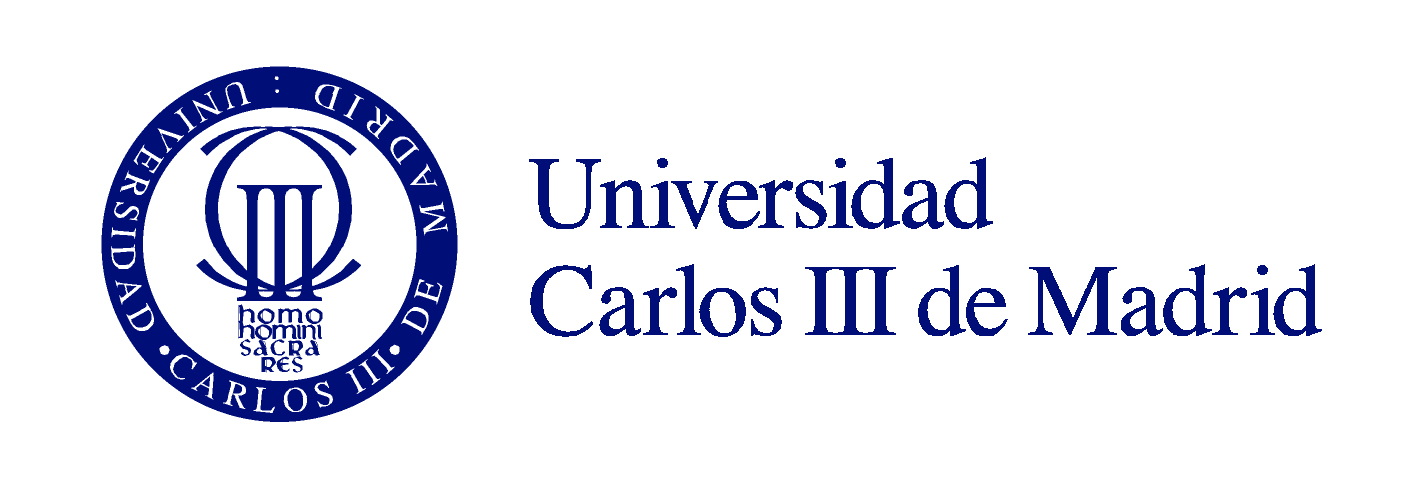

--------------------------
# PREDICCIÓN DEL ABANDONO
--------------------------

Integrantes:

        - Ignacio Marín de la Bárcena Pérez (100432039)
        - Pablo Lago Sanchez-Martinez (100386262)

# Introducción
---------------



En este segundo trabajo, el objetivo es construir modelos para predecir el abandono de empleados en una empresa. Se utilizará un conjunto de datos recopilados por recursos humanos. Se realizarán diferentes preprocesos en los datos, incluyendo la limpieza y transformación de los mismos. Luego se construirán varios modelos de aprendizaje automático, como regresión logística, árboles de decisión o bosques aleatorios. Se entrenarán y validarán los modelos utilizando técnicas de validación cruzada y métricas de evaluación adecuadas. El objetivo es seleccionar el modelo más preciso para predecir el abandono de empleados. Esto permitirá a la empresa tomar medidas preventivas y retener a su personal clave, mejorando la satisfacción laboral y reduciendo la rotación.

# ANÁLISIS EDA
---------------

Realizaremos un análisis EDA (Exploratory Data Analysis) exhaustivo de los datos, que incluirá los siguientes aspectos:

        El número de instancias y atributos en el conjunto de datos.
        La presencia de desequilibrio de clases en el atributo objetivo.
        El tipo de los atributos, es decir, si son variables numéricas, categóricas u otro tipo.
        La identificación de columnas que pueden ser constantes o innecesarias para el análisis.
        La detección y manejo de valores nulos (missing values).
        La determinación del tipo de problema, si es un problema de clasificación o regresión.
En primer lugar, procederemos a cargar los datos y dividirlos, estableciendo el atributo 'Attrition' como nuestra variable objetivo, que indica si un empleado es probable que abandone la empresa o no. Al realizar una primera observación de los valores, se destacan los siguientes hallazgos:

        Hay un total de 711 empleados que son clasificados como probables abandonadores de la empresa.
        Por otro lado, hay 3699 empleados clasificados como probables retentores de la empresa.
Con estos datos iniciales, podremos adentrarnos en el análisis exploratorio para comprender mejor los patrones, características y tendencias presentes en el conjunto de datos, lo que nos permitirá tomar decisiones informadas en la construcción del modelo de predicción de desgaste de empleados.

In [52]:
# Importamos todas las dependencias
# ===========================================
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import time

In [53]:
# Cargamos los datos
# ===========================================
with open('attrition_available_37.pkl','rb') as file:
    datos_df = pickle.load(file)

np.random.seed(37)

# Visualizamos los datos
# ===========================================
datos_df

# Analisis de cuantas instancias y atributos hay (número de atributos e instancias)
# ====================================================================================
print('The shape of the data table is:')
print('===============================')
print(datos_df.shape)
print()

The shape of the data table is:
(4410, 31)



El conjunto de datos consta de 4410 instancias (empleados) con 31 atributos cada una

In [54]:
# Dividimos el dataset
# ===========================================
X = datos_df.drop('Attrition', axis=1)
y = datos_df.Attrition

y.value_counts()

No     3699
Yes     711
Name: Attrition, dtype: int64

Se observa un desbalance significativo en los datos, con una diferencia de casi 3000 entre los empleados que abandonarían la empresa y los que no. Este desbalanceo será considerado en los siguientes puntos del análisis:

        En la división de las muestras en conjuntos de entrenamiento y prueba, se asegurará de mantener la proporción entre las clases para evitar sesgos en la evaluación del modelo.
        Al emplear técnicas de validación cruzada, se garantizará que cada pliegue contenga una distribución equilibrada de ambas clases, permitiendo una evaluación más justa y precisa del rendimiento del modelo.
        Durante el entrenamiento de los modelos, se utilizará el parámetro "class_weight = balanced" con el objetivo de balancear los datos. Este parámetro ajustará automáticamente los pesos de las clases durante el proceso de entrenamiento, contrarrestando así el desbalanceo y evitando que el modelo se sesgue hacia la clase mayoritaria.
Estas medidas tienen como objetivo abordar el desafío del desbalance en los datos, permitiendo un análisis más preciso y equitativo en la predicción del abandono de empleados. Al considerar adecuadamente este desbalance, se busca mitigar posibles sesgos y asegurar resultados más confiables y justos en el desarrollo de los modelos.

In [55]:
print('Tipos de los atributos:')
print('========================')
datos_df.info()

Tipos de los atributos:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 1 to 4409
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      3625 non-null   float64
 1   absences                 3526 non-null   float64
 2   JobInvolvement           3609 non-null   float64
 3   PerformanceRating        3556 non-null   float64
 4   EnvironmentSatisfaction  3562 non-null   float64
 5   JobSatisfaction          3447 non-null   float64
 6   WorkLifeBalance          3661 non-null   float64
 7   Age                      3599 non-null   float64
 8   Attrition                4410 non-null   object 
 9   BusinessTravel           3444 non-null   object 
 10  Department               3697 non-null   object 
 11  DistanceFromHome         4410 non-null   int64  
 12  Education                4410 non-null   int64  
 13  EducationField           3441 non-null   object 
 14  


Dentro de las 31 características presentes en cada instancia, identificamos tres tipos de datos distintos: 19 atributos de tipo coma flotante, 4 atributos de tipo entero y 8 atributos de tipo objeto. Debido a esta variación en los tipos de datos, será necesario abordarlos de manera diferenciada utilizando la función 'transformer'.

Dado que los atributos de tipo coma flotante representan valores numéricos continuos, requerirán un procesamiento específico para asegurar su adecuada escala y normalización. Por otro lado, los atributos de tipo entero, al ser valores numéricos discretos, podrían necesitar ser codificados o tratados de forma particular según los requisitos del modelo.

Por último, los atributos de tipo objeto, que podrían contener información categórica o de texto, requerirán técnicas de codificación adecuadas, como la codificación one-hot o la codificación ordinal, para ser representados de manera numérica y poder ser utilizados en el análisis.

La utilización de la función 'transformer' permitirá abordar estos distintos tipos de datos de manera apropiada, aplicando las transformaciones necesarias para garantizar que los datos estén en un formato compatible con los algoritmos de modelado. De esta manera, se podrá aprovechar la información completa y relevante de los diferentes atributos en la construcción del modelo predictivo.

In [56]:
print('Nombre de los atributos:')
print('========================')
print(datos_df.columns)

Nombre de los atributos:
Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'EmployeeID', 'Gender',
       'JobLevel', 'JobRole', 'MaritalStatus', 'MonthlyIncome',
       'NumCompaniesWorked', 'Over18', 'PercentSalaryHike', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')


C:\Users\imbpe\AppData\Local\Temp\ipykernel_48428\3266775336.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = datos_df.corr()


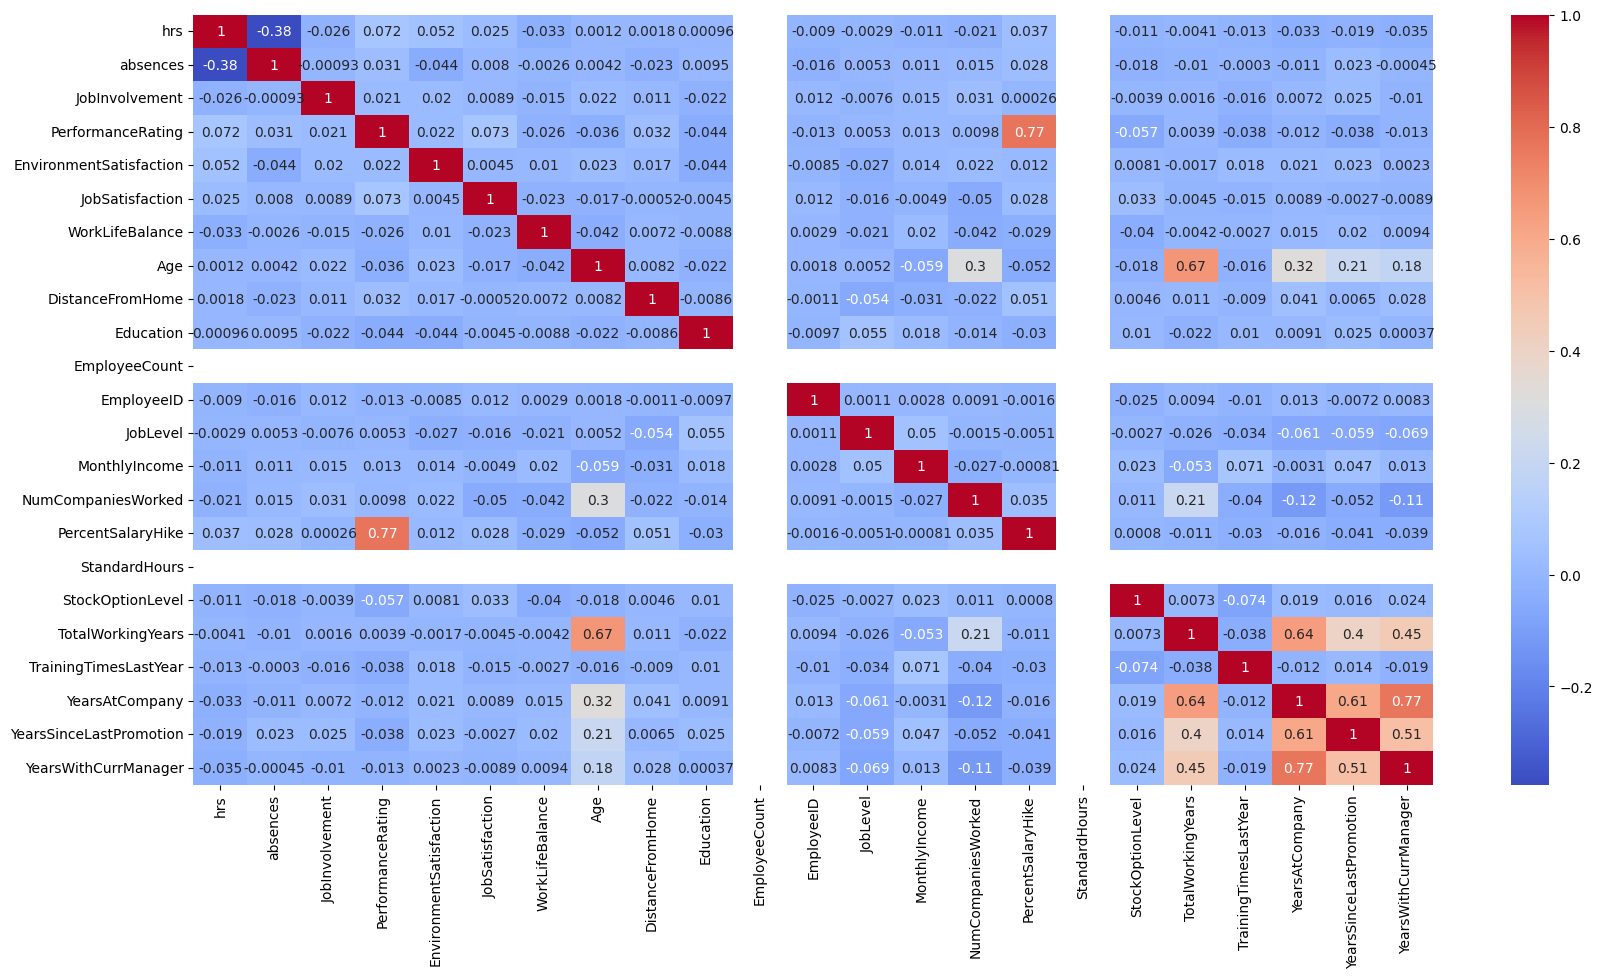

In [57]:
import pandas as pd
import seaborn as sns

# Analizamos la correlación de los atributos
# ===========================================
plt.figure(figsize=(20,10))
corr = datos_df.corr()
sns.heatmap(corr, cmap='coolwarm', annot = True)

plt.show()

In [58]:
# Analizamos los datos
# ======================
datos_df.describe()

,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,DistanceFromHome,Education,...,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
count,3625.000000,3526.000000,3609.000000,3556.000000,3562.000000,3447.000000,3661.000000,3599.000000,4410.000000,4410.000000,...,3519.000000,3655.000000,3508.000000,3553.0,3572.000000,3594.000000,4410.000000,3547.000000,3665.000000,3668.000000
mean,7.303697,12.715542,2.733721,3.157199,2.734700,2.735132,2.765638,36.867463,9.192517,2.912925,...,65757.524865,2.705335,15.213227,8.0,0.797872,11.235949,2.799320,7.029884,2.200546,4.077699
std,1.329108,5.523944,0.716279,0.364040,1.094303,1.101518,0.700296,9.169029,8.105026,1.023933,...,47711.844917,2.504601,3.664677,0.0,0.856893,7.751640,1.288978,6.157201,3.226680,3.543907
min,5.430426,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,18.000000,1.000000,1.000000,...,10090.000000,0.000000,11.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.276813,8.000000,2.000000,3.000000,2.000000,2.000000,2.000000,30.000000,2.000000,2.000000,...,29110.000000,1.000000,12.000000,8.0,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000
50%,6.998131,13.000000,3.000000,3.000000,3.000000,3.000000,3.000000,36.000000,7.000000,3.000000,...,49410.000000,2.000000,14.000000,8.0,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000
75%,7.887540,17.000000,3.000000,3.000000,4.000000,4.000000,3.000000,43.000000,14.000000,4.000000,...,86130.000000,4.000000,18.000000,8.0,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000
max,10.937261,24.000000,4.000000,4.000000,4.000000,4.000000,4.000000,60.000000,29.000000,5.000000,...,199990.000000,9.000000,25.000000,8.0,3.000000,40.000000,6.000000,40.000000,15.000000,17.000000


Al analizar el mapa de calor de las variables, se identifican varios atributos que no son significativos para predecir el modelo. Tras un análisis detallado de los atributos, se llega a la conclusión de que algunos de ellos son innecesarios y no son relevantes para el estudio. Estos atributos son:

        'Employee Count': Representa el número total de empleados en la compañía y presenta una varianza de 0, lo que indica que este atributo no aporta ninguna variabilidad a los datos.
        'Standard Hours': Indica el número de horas trabajadas por el empleado y también muestra una varianza de 0, lo que indica que este atributo no presenta cambios o variación entre los datos.
        'EmployeeID': Es el identificador único asignado a cada empleado, y se considera que no tiene ninguna relación con la decisión de si el empleado abandonará la empresa o permanecerá en ella.
Por lo tanto, se ha decidido eliminar estos atributos del conjunto de datos. Esta decisión está respaldada por el hecho de que no muestran correlación con ninguna otra variable, como se observa en el mapa de calor. Además, la descripción de los datos muestra una desviación estándar (std) de 0 para estos campos. En cuanto al atributo 'EmployeeID', se considera que no influye en la predicción del abandono de la empresa por parte de los empleados, ya que no existe ninguna relación lógica entre el ID y esta decisión.






In [59]:
# Eliminamos aquellos atributos innecesarios y no relevantes para el estudio
# ====================================================
X = X.drop(['EmployeeCount','StandardHours','EmployeeID'], axis=1)
X


,hrs,absences,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,BusinessTravel,Department,...,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
1,7.315971,NaN,2.0,NaN,3.0,2.0,NaN,31.0,NaN,NaN,...,41890.0,0.0,Y,23.0,1.0,NaN,3,5.0,1.0,4.0
6,6.450877,17.0,3.0,4.0,1.0,NaN,1.0,NaN,Travel_Rarely,Research & Development,...,58130.0,2.0,Y,NaN,NaN,5.0,2,0.0,NaN,0.0
13,8.871421,14.0,2.0,3.0,1.0,2.0,2.0,47.0,NaN,Research & Development,...,57620.0,1.0,NaN,NaN,2.0,NaN,4,10.0,9.0,9.0
28,10.713066,6.0,2.0,3.0,4.0,3.0,1.0,NaN,Travel_Frequently,Research & Development,...,NaN,3.0,Y,NaN,1.0,19.0,2,NaN,0.0,0.0
30,NaN,11.0,2.0,3.0,NaN,2.0,3.0,NaN,NaN,Research & Development,...,68540.0,2.0,Y,11.0,0.0,5.0,5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,8.316921,6.0,3.0,3.0,4.0,1.0,NaN,42.0,Travel_Rarely,Research & Development,...,60290.0,3.0,NaN,17.0,1.0,10.0,5,3.0,0.0,2.0
4406,NaN,8.0,2.0,3.0,4.0,4.0,3.0,29.0,Travel_Rarely,Research & Development,...,26790.0,2.0,Y,15.0,0.0,10.0,2,3.0,NaN,2.0
4407,7.149526,18.0,3.0,4.0,1.0,3.0,3.0,25.0,NaN,Research & Development,...,NaN,0.0,NaN,20.0,0.0,5.0,4,NaN,1.0,2.0
4408,9.187612,8.0,2.0,3.0,NaN,NaN,3.0,42.0,Travel_Rarely,Sales,...,23980.0,0.0,Y,14.0,1.0,10.0,2,9.0,7.0,8.0


Ahora analizaremos si se encuntran valores faltantes y nulos. Y en el caso de encontrarse, queremos asber cuantos de estos existen por medio de las funciones isnull.sum() e isnan().sum. Finalmente, expondremos en forma de porcentaje de cuantos de estos faltan (en el caso de que se den).

In [60]:
print('Existen valores nulos:')
print('======================================')
print(X.isnull().any())
print()

Existen valores nulos:
hrs                         True
absences                    True
JobInvolvement              True
PerformanceRating           True
EnvironmentSatisfaction     True
JobSatisfaction             True
WorkLifeBalance             True
Age                         True
BusinessTravel              True
Department                  True
DistanceFromHome           False
Education                  False
EducationField              True
Gender                      True
JobLevel                    True
JobRole                     True
MaritalStatus               True
MonthlyIncome               True
NumCompaniesWorked          True
Over18                      True
PercentSalaryHike           True
StockOptionLevel            True
TotalWorkingYears           True
TrainingTimesLastYear      False
YearsAtCompany              True
YearsSinceLastPromotion     True
YearsWithCurrManager        True
dtype: bool



In [61]:
print('Número de valores nulos:')
print('======================================')
print(X.isnull().sum())
print()

Número de valores nulos:
hrs                        785
absences                   884
JobInvolvement             801
PerformanceRating          854
EnvironmentSatisfaction    848
JobSatisfaction            963
WorkLifeBalance            749
Age                        811
BusinessTravel             966
Department                 713
DistanceFromHome             0
Education                    0
EducationField             969
Gender                     721
JobLevel                   932
JobRole                    966
MaritalStatus              774
MonthlyIncome              891
NumCompaniesWorked         755
Over18                     951
PercentSalaryHike          902
StockOptionLevel           838
TotalWorkingYears          816
TrainingTimesLastYear        0
YearsAtCompany             863
YearsSinceLastPromotion    745
YearsWithCurrManager       742
dtype: int64



In [62]:
print('Porcentaje de valores nulos:')
print('============================')
porcentaje = X.isnull().sum() / len(X) * 100
print(porcentaje)

Porcentaje de valores nulos:
hrs                        17.800454
absences                   20.045351
JobInvolvement             18.163265
PerformanceRating          19.365079
EnvironmentSatisfaction    19.229025
JobSatisfaction            21.836735
WorkLifeBalance            16.984127
Age                        18.390023
BusinessTravel             21.904762
Department                 16.167800
DistanceFromHome            0.000000
Education                   0.000000
EducationField             21.972789
Gender                     16.349206
JobLevel                   21.133787
JobRole                    21.904762
MaritalStatus              17.551020
MonthlyIncome              20.204082
NumCompaniesWorked         17.120181
Over18                     21.564626
PercentSalaryHike          20.453515
StockOptionLevel           19.002268
TotalWorkingYears          18.503401
TrainingTimesLastYear       0.000000
YearsAtCompany             19.569161
YearsSinceLastPromotion    16.893424
YearsWith

Al no superar en ningún atributo el 25% de datos nulos procedemos a tratar estos valores y no eliminar dichos atributos.

In [63]:
# Para instalar la librería missingno
# =========================================

# pip install missingno

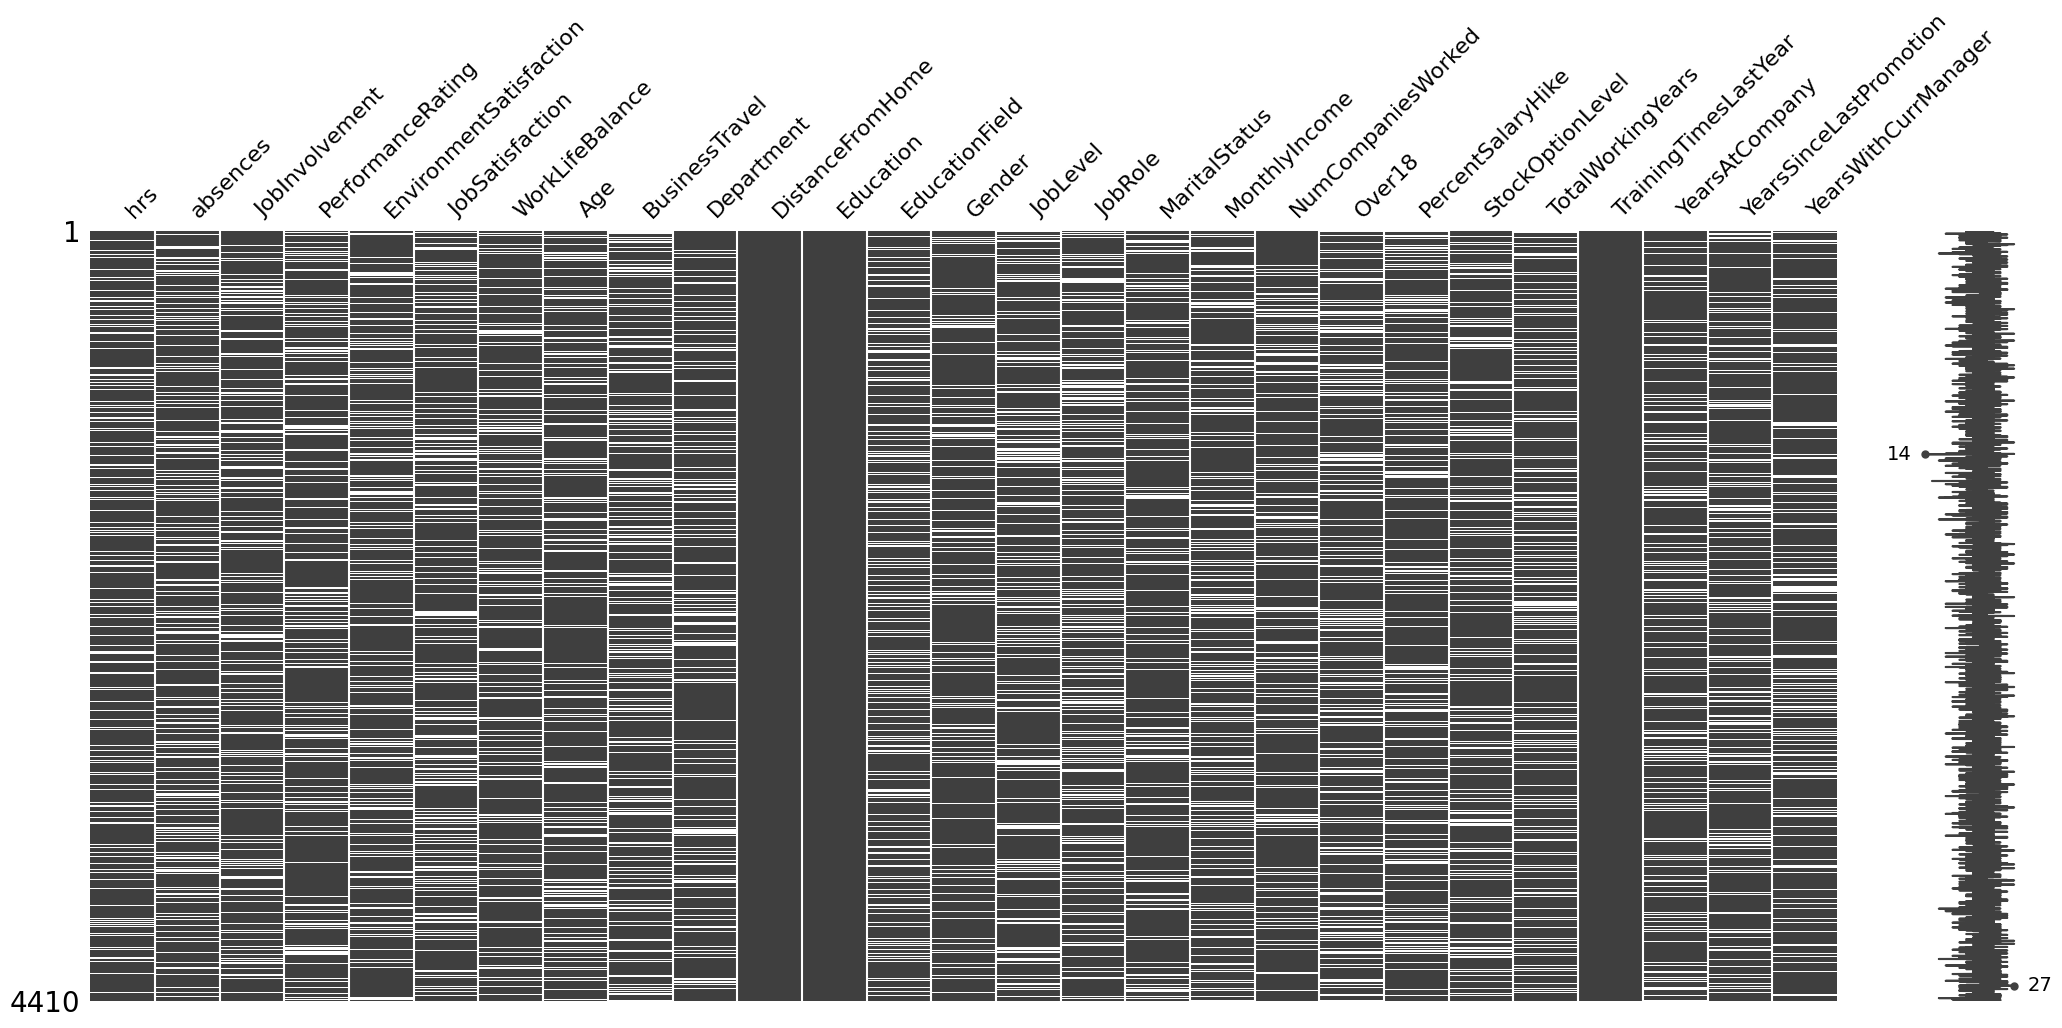

In [64]:
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'png'

msno.matrix(X)
plt.show()

Tras analizar los resultados obtenidos y examinar la gráfica, podemos concluir que existen valores nulos en 26 de los 30 atributos, aunque el porcentaje de estos valores no supera el 25% en ningún caso. Esto indica que no podemos descartar dichos atributos y será necesario aplicar métodos de imputación para tratar los valores faltantes.

En última instancia, podemos concluir que nos enfrentamos a un problema de clasificación en el que los datos presentan un desbalance. Nuestro objetivo es clasificar a los empleados de una empresa en dos categorías: aquellos propensos a abandonar la empresa y aquellos que no lo son. Para abordar este problema, será necesario aplicar técnicas específicas que permitan manejar el desbalance en los datos y obtener un modelo preciso y equilibrado.

En resumen, se identificaron valores nulos en varios atributos, lo que requiere la aplicación de métodos de imputación. Además, se trata de un problema de clasificación con desbalance de clases, en el cual se busca clasificar a los empleados en función de su propensión a abandonar la empresa o no.

# División de los datos
-------------------------

Realizamos una partición de los datos en conjuntos de entrenamiento (80% de los datos) y prueba (20% de los datos). Dado que los datos presentan un desbalance, como mencionamos anteriormente, utilizaremos particiones estratificadas.

El objetivo de utilizar particiones estratificadas es mantener la proporción de las clases en cada conjunto de manera representativa. Esto es especialmente importante cuando se enfrenta un desbalance, ya que nos aseguramos de que tanto el conjunto de entrenamiento como el de prueba contengan una distribución equilibrada de las clases. De esta manera, evitamos sesgos y garantizamos una evaluación justa y precisa del rendimiento del modelo en ambas categorías.

Al aplicar particiones estratificadas, buscamos obtener resultados más confiables y robustos, ya que cada conjunto de datos reflejará adecuadamente la proporción de empleados que abandonan la empresa y los que no. Esto nos permitirá entrenar y evaluar el modelo de manera más precisa y tomar decisiones informadas basadas en la realidad del desgaste de los empleados.

In [65]:
# Seleccionados train/test en modo stratify, ya que el dataset se encuentra desbalanceado y con datos de diferentes tipos.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, train_size=0.8)

# Codificamos la salida
------------------------

Procedemos a codificar la salida 'Attribution' dicotómica ('SÍ' o 'NO') con LabelEncoder ya que nos sera útil para el calculo de las funciones ROC.

In [66]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)

# Codificamos la salida
# =======================================
y_test = le.transform(y_test)
y_train = le.transform (y_train)

# Análisis de las variables
----------------------------
Una vez que hemos codificado la variable objetivo y analizado los datos, procedemos a realizar el tratamiento de las variables de entrada. Dado que hemos identificado diferentes tipos de variables, aplicaremos distintos enfoques para cada una de ellas:

    Variables numéricas (float e int): Aplicaremos un preprocesamiento utilizando la técnica de imputación por medio de los vecinos más cercanos (kNN) para reemplazar los valores faltantes por la media calculada a partir de los vecinos más cercanos en el conjunto de datos.

    PCA (Análisis de Componentes Principales): Reduciremos la dimensionalidad del conjunto de datos aplicando la técnica de PCA. Esto nos permitirá transformar las variables en un conjunto más pequeño que retenga la mayor cantidad de información posible, simplificando la representación de los datos sin perder significado.

    Variables categóricas (Object) - One-Hot Encoding: Emplearemos la técnica de codificación One-Hot Encoding para convertir las variables categóricas en variables numéricas binarias. Esta técnica asignará el valor 1 a la presencia de una categoría y el valor 0 a la ausencia de la misma. De esta manera, se asegura que todas las categorías estén representadas de forma adecuada en el análisis y modelado.

Al aplicar estos tratamientos específicos para cada tipo de variable, buscamos asegurar la calidad y compatibilidad de los datos en la construcción de los modelos, permitiéndonos aprovechar toda la información disponible y facilitando la interpretación y el análisis de los resultados obtenidos.

In [67]:
X_train.dtypes

hrs                        float64
absences                   float64
JobInvolvement             float64
PerformanceRating          float64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
Age                        float64
BusinessTravel              object
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
Gender                      object
JobLevel                   float64
JobRole                     object
MaritalStatus               object
MonthlyIncome              float64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike          float64
StockOptionLevel           float64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany             float64
YearsSinceLastPromotion    float64
YearsWithCurrManager       float64
dtype: object

In [68]:
obj_cols = X_train.select_dtypes(include="object").columns
num_cols = X_train.select_dtypes(exclude="object").columns

In [69]:
print('Atributos numéricos')
print('=====================')
print(num_cols)
print()

print('Atributos object')
print('====================')
print(obj_cols)
print()

Atributos numéricos
Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

Atributos object
Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18'],
      dtype='object')



Observamos un mayor número de variables numéricas que object. Siendo necesario crear un pipeline capaz de procesar ambos tipos de variables.

Para las variables categóticas vamos a crear un pipeline donde:
1. Si hubiese una muestra con valores nulos, le vamos a imputar el valor del más frecuente.
2. Codificaremos con la técnicas One_Hot_Encoder.
3. Aplicaremos sobre ellos un PCA, para extraer características más discriminantes

In [70]:
# Tratamos las variables object
# ======================================
obj_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # De todos los que tiene coge el más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
    ('pca', PCA(n_components=5))
])

In [71]:
# Primer paso del pipeline
# ==========================
obj_transformer[0]

SimpleImputer(strategy='most_frequent')

Ahora respecto a las variables numéricas, vamos a realizar el siguiente preproceso:
1. Si hay valores nulos, vamos a asignarles la media de sus K=5 vecinos más cercanos.
2. Realizaremos un escalado

In [72]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler

# Tratamos las variables numéricas
# ======================================
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

Aplicamos la función `ColumnTransformer` para indicar cómo procesara el calsificador las variables categóricas (object) y numéricas. Empleando el transformador correcto para cada tipo de variable.

In [73]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('obj', obj_transformer, obj_cols)
    ])

In [74]:
# Como funciona nuestro transformador
# ====================================
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', RobustScaler())]),
                                 Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome',
       'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLe...
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')),
                                ('obj',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('pca', PCA(n_components=5))]),
                                 Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18'],
      dtype='object'))])

Como se extrae de la imagen anterior, nuestro transformador aplica dos transformaciones en función de la variables:

        - En caso de encontrarse ante valores nulos en una variable numérica, le asignamos el valor medio de sus vecinos (explicado anteriormente). Para después, realizar un escalado robusto.

        - Por otro lado, si la variable es de tipo objeto realizamos un 'SimpleImputer' en el que asignamos el valor más frecuente en caso de encontrar un valor nulo. Para despues aplicar 'OneHotEncoder' y transformarlo a una variable binaria y finalmente 'PCA' para las características discriminantes.

# Creamos el clasificador modelo logistic regression
-------------------------------------------------------
Una vez creado el preprocesador de los datos, procedemos a crear el primer modelo 'Logistic regression'. Para ello, haremos uso del parámetro 'class_weight' al encontrarse los datos desbalanceados. Finalmente, aplicaremos búsqueda de hiper-parámetros por el método 'GRID SEARCH' con la intención de mejorar el modelo.

In [75]:
from sklearn.linear_model import LogisticRegression

# Pipeline del clasificador
# =========================
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(class_weight='balanced',random_state=37))])

np.random.seed(37)

Observamos el clasificador en su totalidad

In [76]:
# Definimos el clasificador con todos sus procesos
# =================================================
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome',
       'NumCompaniesWorked', 'P...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18'],
      dtype='object'))])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', random_state=37))])

Como se extraemos de la imagen anterior, nuestro clasificador aplica las transformaciones explicadas anteriormente dentro del Pipeline, para aplicar depués el método LogisticRegression para clasificación.

In [77]:
# Calculamos la media del modelo para un cross validation de 5
# ===============================================================
cross_val_score(clf, X_train, y_train, cv=5, scoring="balanced_accuracy").mean()

0.6919871401129779

Tras realizar la validación cruzada obtenemos que el promedio de las puntuaciones de 'balanced accuracy' es de 0,69 es decir, tenemos una estimación del rendimiento del clasificador 'Logistic regression' para el conjunto de datos de 0,69. Valor que se puede mejorar siento lo recomendable en torno al 0,8.

## Modelo Logistic Regression sin búsqueda de hiper-parámetros

In [78]:
# Entrenamos el modelo
# ===================================
start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()

print('Tiempo de entrenamiento de LogisticRegression - sin ajuste de hiperparámetros: ', end_time - start_time, 'segundos')

Tiempo de entrenamiento de LogisticRegression - sin ajuste de hiperparámetros:  1.759803295135498 segundos


In [79]:
# Predecimos los resultados
# ======================================
y_pred = clf.predict(X_test)

print('Los resultados predecidos son:')
print('================================')
# Convertir arreglo a objeto Series de Pandas
y_pred_series = pd.Series(y_pred)

# Contar ocurrencias de cada valor único
value_counts = y_pred_series.value_counts()
print(value_counts)

Los resultados predecidos son:
0    571
1    311
dtype: int64


Se observa que un mayor porcentaje de los empleados permaneceran en la empresa para estos datos y el modelo:

        - 0 empleados que permanecen de la empresa.
        - 1 empleados que se marcharían de la empresa.

In [80]:
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

# Calculamos el report de la clasificación
# ============================================
print(classification_report(y_test, y_pred))
print()

# Resultado de la precisión del balance de los datos
# ===================================================
lg = balanced_accuracy_score(y_test, y_pred)
print(f"El valor de balanced accuracy - LogisticRegression: {lg}")

              precision    recall  f1-score   support

           0       0.92      0.71      0.81       740
           1       0.32      0.70      0.44       142

    accuracy                           0.71       882
   macro avg       0.62      0.71      0.62       882
weighted avg       0.83      0.71      0.75       882


El valor de balanced accuracy - LogisticRegression: 0.7053483060525314


En el resumen de los resultados, observamos una precisión del 92% para los empleados que no se van y del 32% para aquellos que sí lo hacen. Estos valores indican que el modelo tiene una precisión muy baja en la predicción de empleados propensos a abandonar la empresa. Además, se observa que tanto el valor de "recall" como el "f1-score" son bastante bajos para los empleados clasificados como propensos a marcharse, lo cual indica una baja capacidad del modelo para identificar correctamente esta categoría.

En general, la precisión de balanceo del modelo es del 70,53%, lo cual refleja un rendimiento moderado en términos de equilibrio entre la precisión en ambas categorías. Sin embargo, es importante tener en cuenta que el modelo presenta una precisión significativamente más baja en la categoría de empleados propensos a abandonar la empresa.

Estos resultados sugieren que se requiere una mejora en la capacidad de predicción del modelo, especialmente en la identificación de empleados que pueden abandonar la empresa. 

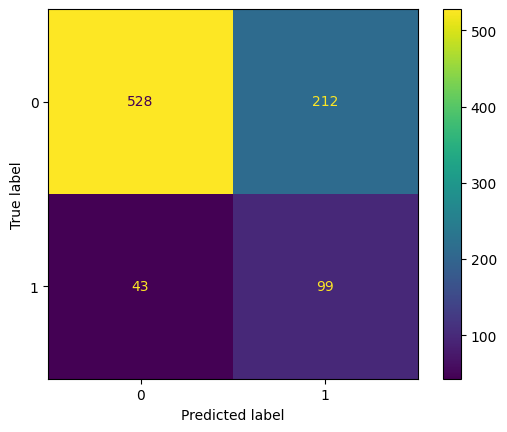

In [81]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Matriz de confusión
# =====================
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

En la matriz de confusión se observa que este modelo clasifica correctamente 528 para los empleados que se quedan y 99 para los que están dispuestos a irse. A su vez, el modelo clasifica de forma erronea 255 empleados, de los cuales 212 si permanecerían en la empresa y los clasifica como que se irian y 43 que los clasifica como que permanecerían cuando en verdad abandonarían la empresa.

Estos resultados erroneos coinciden con el resultado obtenido anteriormente para el 'balanced accuracy' dada la precisión del modelo.

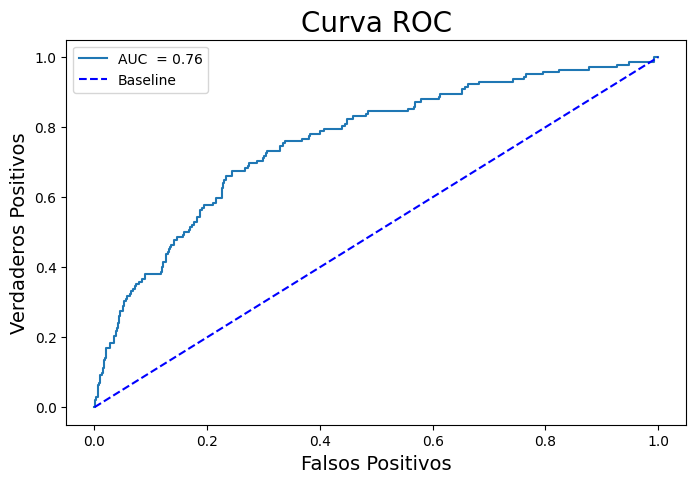

In [82]:
# Curva ROC y el área bajo la curva (AUC)
# =========================================
probs = clf.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend()

De la curva ROC y del valor AUC podemos analizar nuevamente el rendimiento de nuestro modelo. Debido a un valor de AUC (es el área bajo la curva) de 0,76 encontramos que nuestro clasificador proporciona un rendimiento medio indicando una sensibilidad media (el valor de verdaderos positivos no se acerca rapidamente a 1) y y una tasa media de falsos positivos.  

## Modelo Logistic Regression con búsqueda de hiper-parámetros

Los hiperparámetros son:

        -penalty: Especifica la técnica de regularización empleada para así evitar el sobreajuste.

        -C: Representa el inverso de la fuerza de regularización. A un mayor valor de C menos regularización.

        -Solver: Optimiza los pesos las variables

In [83]:
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV, cross_val_score


logistic_grid = {'classifier__penalty': ['l1', 'l2', 'elascticnet'],
               'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'classifier__solver': ['lbfgs', 'liblinear', 'sag', 'saga']}          

inner = KFold(n_splits=3, shuffle=True, random_state=37)

# Cross-validation (3-fold) para la búsqueda de hiper-parámetros
clf = GridSearchCV (estimator  = clf,
                    param_grid = logistic_grid,
                    scoring='balanced_accuracy',
                    cv=inner,
                    refit=True,
                    n_jobs=-1,
                    verbose=1,
                    return_train_score=True)

np.random.seed(37)

Realizamos una búsqueda de los mejores hiper-pámetros del modelo para mejorar su rendimiento.

In [84]:
# Definimos el clasificador con todos sus procesos
# =============================================================================
clf

GridSearchCV(cv=KFold(n_splits=3, random_state=37, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          RobustScaler())]),
                                                                         Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'Distanc...
       'MaritalStatus', 'Over18'],
      dtype='object'))])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           random_state=37))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'classifier__penalty': ['l1', 'l2', 'elascticnet'],
                         'classifier__solver': ['lbfgs', 'liblinear', 'sag',
                                                'saga']},
             return_train_score=True, scoring='balanced_accuracy', verbose=1)

In [85]:
# Entrenamos el modelo
# ===================================
start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()

print('Tiempo de entrenamiento de LogisticRegression - con ajuste de hiperparámetros: ', (end_time - start_time), 'segundos')

Fitting 3 folds for each of 84 candidates, totalling 252 fits


c:\Users\imbpe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
126 fits failed out of a total of 252.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\imbpe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\imbpe\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\imbpe\AppData\Local\Programs\Python\Python39\lib\site

Tiempo de entrenamiento de LogisticRegression - con ajuste de hiperparámetros:  105.77885580062866 segundos


In [86]:
# Mejor resultado
# ===================================
clf.best_score_

0.6835184020416873

In [87]:
# Mejores valores para cada hiper-parámetro
# ============================================
clf.best_params_

{'classifier__C': 0.1,
 'classifier__penalty': 'l1',
 'classifier__solver': 'saga'}

In [88]:
# Predecimos los resultados
# ======================================
y_pred = clf.predict(X_test)

print('Los resultados predecidos son:')
print('================================')
# Convertir arreglo a objeto Series de Pandas
y_pred_series = pd.Series(y_pred)

# Contar ocurrencias de cada valor único
value_counts = y_pred_series.value_counts()
print(value_counts)
print()

Los resultados predecidos son:
0    575
1    307
dtype: int64



Se observa que un mayor porcentaje de los empleados permaneceran en la empresa para estos datos y el modelo:

        - 0 empleados que permanecen de la empresa.
        - 1 empleados que se marcharían de la empresa.

In [89]:
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

# Calculamos el report de la clasificación
# ============================================
print(classification_report(y_test, y_pred))
print()

# Resultado de la precisión del balance de los datos
# ===================================================
lgG = balanced_accuracy_score(y_test, y_pred)
print(f"El valor de balanced accuracy: {lgG}")

              precision    recall  f1-score   support

           0       0.93      0.72      0.81       740
           1       0.32      0.70      0.44       142

    accuracy                           0.72       882
   macro avg       0.62      0.71      0.63       882
weighted avg       0.83      0.72      0.75       882


El valor de balanced accuracy: 0.7080510087552341


En el resumen de resultados, se observa una precisión del 93% para los empleados que deciden quedarse y del 32% para aquellos que optan por abandonar la empresa. Estos valores indican que el modelo tiene una precisión muy baja en la predicción de empleados propensos a marcharse, lo cual es una limitación importante del modelo en ese aspecto.

Además, los valores de "recall" y "f1-score" son considerablemente bajos para los empleados clasificados como propensos a abandonar, lo que refleja una capacidad deficiente del modelo para identificar correctamente esta categoría. Estos resultados señalan la necesidad de mejorar la capacidad del modelo para detectar adecuadamente a los empleados que están en riesgo de dejar la empresa.

En términos de precisión de balanceo, se obtiene un valor del 70,81%. Si bien indica un rendimiento moderado en términos de equilibrio entre las dos categorías, es importante destacar que la precisión en la categoría de empleados propensos a marcharse sigue siendo relativamente baja.

Estos hallazgos subrayan la importancia de mejorar el modelo en la predicción de empleados que están en riesgo de abandonar la empresa. 

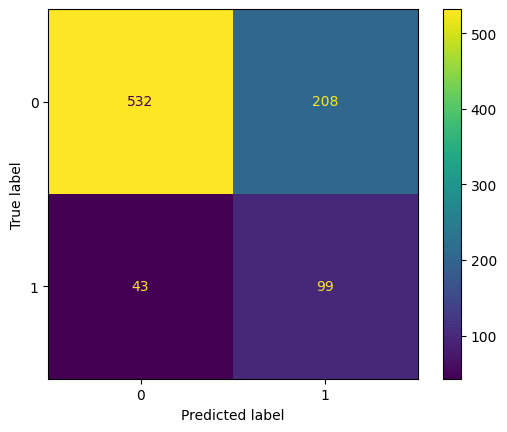

In [90]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Matriz de confusión
# =====================
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

En la matriz de confusión se observa que este modelo clasifica correctamente 532 para los empleados que se quedan y 99 para los que están dispuestos a irse. A su vez, el modelo clasifica de forma erronea 251 empleados, de los cuales 208 si permanecerían en la empresa y los clasifica como que se irian y 43 que los clasifica como que permanecerían cuando en verdad abandonarían la empresa.

Estos resultados erroneos coinciden con el resultado obtenido anteriormente para el 'balanced accuracy' dada la precisión del modelo.

Aclarar que no supone una gran mejora respecto al modelo sin trata de hiper-parámetros.

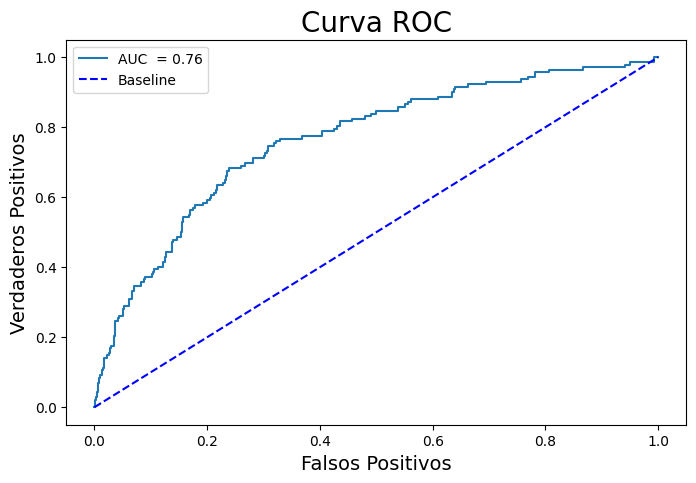

In [91]:
# Curva ROC y el área bajo la curva (AUC)
# =========================================
probs = clf.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend()

De la curva ROC y del valor AUC podemos analizar nuevamente el rendimiento de nuestro modelo. Debido a un valor de AUC (es el área bajo la curva) de 0,76 encontramos que nuestro clasificador proporciona un rendimiento medio indicando una sensibilidad media (el valor de verdaderos positivos no se acerca rapidamente a 1) y y una tasa media de falsos positivos.

No supone una mejora respecto al modelo sin trara hiper-parámetros

# Creamos el clasificador modelo boosting
------------------------------------------
El modelo que emplearemos para el clasificador es un método avanzado de boosting denominado 'HistGradientBoostingClassifier'. Para el cual, realizaremos una búsqueda de los mejores hiper-parámetros usando 'Randomized Search CV' como ajuste de hiper-parámetros. Mencionar que al igual que empleamos para el 'Logistic regression', haremos uso del parámetro 'class_weight' al encontrarse los datos desbalanceados


In [92]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier

# Pipeline del clasificador
# =================================================
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', HistGradientBoostingClassifier(class_weight='balanced', random_state=37))])

np.random.seed(37)

Observamos el clasificador en su totalidad

In [93]:
# Definimos el clasificador con todos sus procesos
# =================================================
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome',
       'NumCompaniesWorked', 'P...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18'],
      dtype='object'))])),
                ('classifier',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                random_state=37))])

Como se extraemos de la imagen anterior, nuestro clasificador aplica las transformaciones explicadas anteriormente dentro del Pipeline, para aplicar depués el método HistGradientBoostingClassifier para clasificación.

In [94]:
# Calculamos la media del modelo para un cross validatio de 5
# ===============================================================
cross_val_score(clf, X_train, y_train, cv=5, scoring="balanced_accuracy").mean()

0.787928435079932

Realizando la validación cruzada obtenemos que el promedio de las puntuaciones de 'balanced accuracy' es de 0,79 es decir, tenemos una estimación del rendimiento del clasificador 'HistGradientBoosting' para el conjunto de datos de 0,79. Valor que supone una mejora del 10% respecto al modelo anterior.

## Modelo boosting sin búsqueda de hiper-parámetros

In [95]:
# Entrenamos el modelo
# ===================================
start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()

print('Tiempo de entrenamiento de HistGradientBoosting - sin ajuste de hiperparámetros: ', end_time - start_time, 'segundos')

Tiempo de entrenamiento de HistGradientBoosting - sin ajuste de hiperparámetros:  3.2284836769104004 segundos


In [96]:
# Predecimos los resultados
# ======================================
y_pred = clf.predict(X_test)

print('Los resultados predecidos son:')
print('================================')
# Convertir arreglo a objeto Series de Pandas
y_pred_series = pd.Series(y_pred)

# Contar ocurrencias de cada valor único
value_counts = y_pred_series.value_counts()
print(value_counts)

Los resultados predecidos son:
0    749
1    133
dtype: int64


Se observa que un mayor porcentaje de los empleados permaneceran en la empresa para estos datos y el modelo:

        - 0 empleados que permanecen de la empresa.
        - 1 empleados que se marcharían de la empresa.

In [97]:
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

# Calculamos el report de la clasificación
# ============================================
print(classification_report(y_test, y_pred))
print()

# Resultado de la precisión del balance de los datos
# ===================================================
bo = balanced_accuracy_score(y_test, y_pred)
print(f"El valor de balanced accuracy - HistGradientBoosting: {bo}")

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       740
           1       0.74      0.69      0.71       142

    accuracy                           0.91       882
   macro avg       0.84      0.82      0.83       882
weighted avg       0.91      0.91      0.91       882


El valor de balanced accuracy - HistGradientBoosting: 0.8214217738865626


En el resumen de resultados, se destaca una precisión del 94% para los empleados que deciden quedarse y del 74% para aquellos que optan por abandonar la empresa. Estos valores indican que el modelo tiene una precisión mediana en la predicción de empleados en ambos grupos.

No obstante, al observar los valores de "recall" y "f1-score" para los empleados clasificados como propensos a marcharse, se aprecia que son bastante bajos. Esto sugiere que el modelo tiene dificultades para identificar correctamente a esta categoría específica de empleados, lo que implica que existe una proporción de empleados en riesgo de abandonar la empresa que no están siendo identificados de manera adecuada.

En cuanto a la precisión de balanceo, se obtiene un valor del 82,14%, lo cual indica un rendimiento moderado en términos de equilibrio entre ambas categorías.

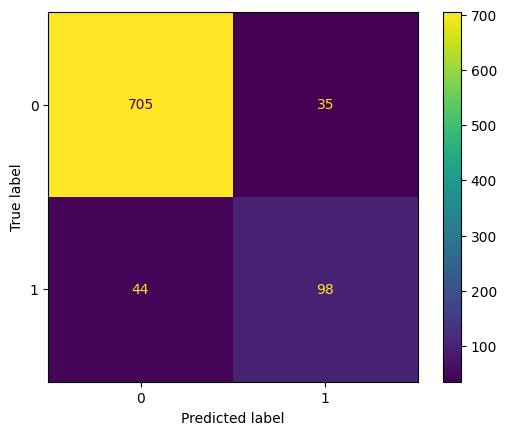

In [98]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Matriz de confusión
# =====================
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

En la matriz de confusión se observa que este modelo clasifica correctamente 705 para los empleados que se quedan y 98 para los que están dispuestos a irse. A su vez, el modelo clasifica de forma erronea 79 empleados, de los cuales 35 si permanecerían en la empresa y los clasifica como que se irian y 44 que los clasifica como que permanecerían cuando en verdad abandonarían la empresa.

Estos resultados a pesar de tener clasificaciones erróneas presentan una mayor precisión.

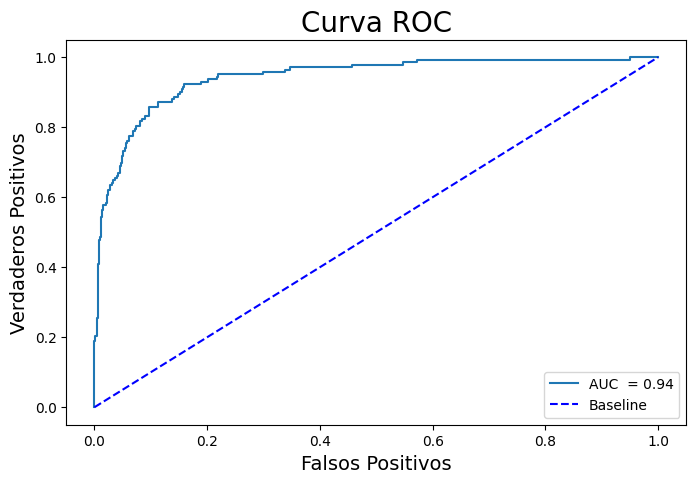

In [99]:
# Curva ROC y el área bajo la curva (AUC)
# =========================================
probs = clf.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend()

De la curva ROC y del valor AUC podemos analizar nuevamente el rendimiento de nuestro modelo. Debido a un valor de AUC (es el área bajo la curva) de 0,94 encontramos que nuestro clasificador proporciona un rendimiento medio indicando una sensibilidad alta (el valor de verdaderos positivos se acerca rapidamente a 1) y y una tasa baja de falsos positivos.

## Modelo boosting con búsqueda de hiper-parámetros por Randomized Search

Los hiperparámetros del algoritmo de Gradient Boosting son:

        -learning_rate: Factor de aprendizaje que controla la tasa de aprendizaje del algoritmo. Valores más bajos harán que el modelo sea más lento, pero pueden dar mejores resultados.

        -n_estimators: Número de árboles de decisión que se utilizarán en el modelo. Valores más altos darán modelos más complejos y precisos, pero también aumentarán el tiempo de entrenamiento y el riesgo de sobreajuste.

        -max_depth: Profundidad máxima de cada árbol. Controla la complejidad del modelo. Valores más altos permitirán modelos más complejos, pero también aumentarán el riesgo de sobreajuste.

        -min_samples_split: El número mínimo de muestras requeridas para dividir un nodo. Valores más altos evitarán que el modelo sea demasiado complejo, pero también pueden reducir la precisión.

        -min_samples_leaf: El número mínimo de muestras requeridas en cada hoja del árbol. Al igual que con min_samples_split, valores más altos evitarán que el modelo sea demasiado complejo, pero también pueden reducir la precisión.

        -max_features: El número máximo de características que se considerarán al dividir un nodo. Valores más bajos pueden evitar la complejidad excesiva, pero también pueden reducir la precisión.

In [100]:
# Búsqueda de hiperparámetros de todos los valores
# ==================================================
from sklearn.model_selection import RandomizedSearchCV

num_transformer_dist = {'preprocessor__num__imputer__n_neighbors': list(range(2, 10)),
                        'preprocessor__num__imputer__add_indicator': [True, False]}

obj_transformer_dist = {'preprocessor__obj__imputer__strategy': ['most_frequent', 'constant'],
                        'preprocessor__obj__imputer__add_indicator': [True, False],
                        'preprocessor__obj__pca__n_components': list(range(2, 15))}

gradient_boosting_dist = {'classifier__learning_rate':[0.01, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1],
                          'classifier__max_depth': [None, 1, 3, 5, 10, 13, 15, 18, 20],
                          'classifier__min_samples_leaf': [1, 2, 3, 4, 5, 10, 13, 15, 18, 20],
                          'classifier__max_leaf_nodes': [3, 10, 30, 40, 50, 60, 70],
                          'classifier__l2_regularization': [0, 0.1, 0.4, 0.5, 0.7, 0.8, 0.9, 1, 1.25, 1.5, 1.75, 2]}

param_dist = {**num_transformer_dist, **obj_transformer_dist, **gradient_boosting_dist}

# Creamos el modelo
# ====================================================
random_search_GB = RandomizedSearchCV(clf,
                                   param_distributions=param_dist,
                                   error_score='raise',
                                   n_iter=200)

Realizamos una búsqueda de los mejores hiper-pámetros del modelo para mejorar su rendimiento.

In [101]:
# Definimos el clasificador con todos sus procesos
# =============================================================================
random_search_GB

RandomizedSearchCV(error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', '...
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         3, 4,
                                                                         5, 10,
                                                                         13, 15,
                                                                         18,
                                                                         20],
                                        'preprocessor__num__imputer__add_indicator': [True,
                                                                                      False],
                                        'preprocessor__num__imputer__n_neighbors': [2,
                                                                                    3,
                                                                                    4,
                                                                                    5,
                                                                                    6,
                                                                                    7,
                                                                                    8,
                                                                                    9],
                                        'preprocessor__obj__imputer__add_indicator': [True,
                                                                                      False],
                                        'preprocessor__obj__imputer__strategy': ['most_frequent',
                                                                                 'constant'],
                                        'preprocessor__obj__pca__n_components': [2,
                                                                                 3,
                                                                                 4,
                                                                                 5,
                                                                                 6,
                                                                                 7,
                                                                                 8,
                                                                                 9,
                                                                                 10,
                                                                                 11,
                                                                                 12,
                                                                                 13,
                                                                                 14]})

In [102]:
# Entrenamos el modelo
# ===================================
start_time = time.time()
random_search_GB.fit(X_train, y_train)
end_time = time.time()

print('Tiempo de entrenamiento de HistGradientBoosting - con ajuste de hiperparámetros: ', (end_time - start_time)/60, 'minutos')

Tiempo de entrenamiento de HistGradientBoosting - con ajuste de hiperparámetros:  49.05344662666321 minutos


In [103]:
# Mejor resultado
# ===================================
random_search_GB.best_score_

0.9200703192493922

In [104]:
# Mejores valores para cada hiper-parámetro
# ============================================
random_search_GB.best_params_

{'preprocessor__obj__pca__n_components': 2,
 'preprocessor__obj__imputer__strategy': 'constant',
 'preprocessor__obj__imputer__add_indicator': False,
 'preprocessor__num__imputer__n_neighbors': 2,
 'preprocessor__num__imputer__add_indicator': False,
 'classifier__min_samples_leaf': 3,
 'classifier__max_leaf_nodes': 30,
 'classifier__max_depth': 18,
 'classifier__learning_rate': 0.25,
 'classifier__l2_regularization': 0.5}

In [105]:
# Predecimos los resultados
# ======================================
y_pred = random_search_GB.predict(X_test)

print('Los resultados predecidos son:')
print('================================')
# Convertir arreglo a objeto Series de Pandas
y_pred_series = pd.Series(y_pred)

# Contar ocurrencias de cada valor único
value_counts = y_pred_series.value_counts()
print(value_counts)
print()

Los resultados predecidos son:
0    770
1    112
dtype: int64



Se observa que un mayor porcentaje de los empleados permaneceran en la empresa para estos datos y el modelo:

        - 0 empleados que permanecen de la empresa.
        - 1 empleados que se marcharían de la empresa.

In [106]:
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

# Calculamos el report de la clasificación
# ============================================
print(classification_report(y_test, y_pred))
print()

# Resultado de la precisión del balance de los datos
# ===================================================
boR = balanced_accuracy_score(y_test, y_pred)
print(f"El valor de balanced accuracy: {boR}")

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       740
           1       0.91      0.72      0.80       142

    accuracy                           0.94       882
   macro avg       0.93      0.85      0.89       882
weighted avg       0.94      0.94      0.94       882


El valor de balanced accuracy: 0.8523981728207081


En el resumen de resultados, se destaca una precisión del 95% para los empleados que deciden quedarse y del 91% para aquellos que optan por abandonar la empresa. Estos valores indican que el modelo tiene una precisión bastante alta en la predicción de los empleados en ambos grupos, lo cual es positivo.

Sin embargo, al observar los valores de "recall" y "f1-score" para los empleados clasificados como propensos a marcharse, se aprecia que son regulares, lo que sugiere que el modelo tiene dificultades para identificar correctamente esta categoría específica. Esto implica que existe una proporción de empleados que podrían abandonar la empresa pero no están siendo identificados de manera adecuada por el modelo.

En cuanto a la precisión de balanceo, se obtiene un valor del 85,24%, lo cual indica un rendimiento razonable en términos de equilibrio entre ambas categorías. No obstante, es importante destacar que se puede buscar mejorar la precisión en la detección de empleados propensos a marcharse para obtener un mejor equilibrio entre ambas categorías.

Con estos resultados, se evidencia que el modelo tiene una buena precisión general en la clasificación de empleados, pero existe margen para mejorar la identificación de aquellos que están en riesgo de abandonar la empresa

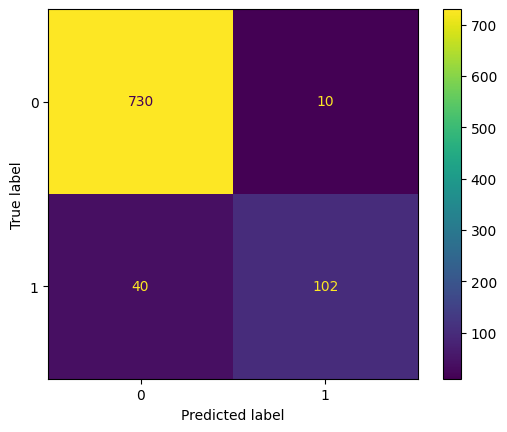

In [107]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Matriz de confusión
# =====================
cm = confusion_matrix(y_test, y_pred, labels=random_search_GB.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=random_search_GB.classes_)
disp.plot()
plt.show()

En la matriz de confusión se observa que este modelo clasifica correctamente 730 para los empleados que se quedan y 102 para los que están dispuestos a irse. A su vez, el modelo clasifica de forma erronea 50 empleados, de los cuales 10 si permanecerían en la empresa y los clasifica como que se irian y 40 que los clasifica como que permanecerían cuando en verdad abandonarían la empresa.

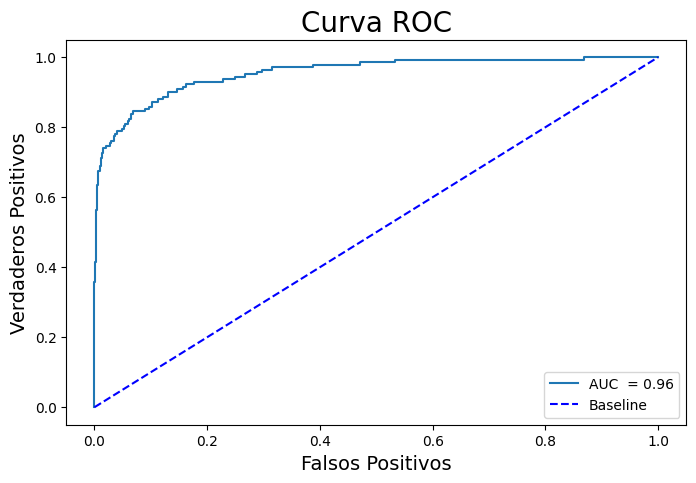

In [108]:
# Curva ROC y el área bajo la curva (AUC)
# =========================================
probs = random_search_GB.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend()

De la curva ROC y del valor AUC podemos analizar nuevamente el rendimiento de nuestro modelo. Debido a un valor de AUC (es el área bajo la curva) de 0,96 encontramos que nuestro clasificador proporciona un rendimiento medio indicando una sensibilidad alta (el valor de verdaderos positivos se acerca rapidamente a 1) y y una tasa baja de falsos positivos.

# Creamos el clasificador modelo XGBoost
-----------------------------------------
Una vez ajustado un modelo Gradient Boosting con y sin ajuste de hiper-parámetros. Realizaremos una implementación de Gradient boosting denominada XGBoost.

Esta Implementación utiliza múltiples modelos débiles (generalmente árboles de decisión al igual que el gradient boost) para mejorar la precisión predictiva del modelo. Cada uno de los modelos se ajusta con los errores de predicción del modelo anterior, aumentando así la precisión del modelo en cada iteración. Cabe mencionar que utiliza técnicas de regularización y valores perdidos evitando así el sobre ajuste y mejorando la capacidad de generalización del modelo.

A diferencia de los anteriores modelos, esté no emplea el argumento 'class_weight' cuando los datos se encuentran desbalanceados. Es por ello, que hemos hecho uso de su igual pero para el modelo indicado denominandose este argumento 'Scale_pos_weight', el cual se calcula de la siguiente forma:

        scale_pos_weight = sum(negative instances) / sum(positive instances)

Argumento que nos ha permitido balancear los datos.

In [109]:
# Para instalar la librería XGBoost
# =========================================

# pip install xgboost

In [110]:
from xgboost import XGBClassifier
import multiprocessing

# Para balancear el modelo
# ==========================
positive_records = y_train.sum()
negative_records = len(y_train) - positive_records
spw = negative_records - positive_records

# Pipeline del clasificador
# =================================================
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', XGBClassifier(scale_pos_weight = spw, random_state=37))])

np.random.seed(37)

Observamos el clasificador en su totalidad

In [111]:
# Definimos el clasificador con todos sus procesos
# =================================================
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome',
       'NumCompaniesWorked', 'P...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=37, ...))])

Como lo extraemos de la imagen anterior, nuestro clasificador aplica las transformaciones explicadas anteriormente dentro del Pipeline, para aplicar depués el método XGBoost para clasificación.

In [112]:
# Calculamos la media del modelo para un cross validatio de 5
# ===============================================================
cross_val_score(clf, X_train, y_train, cv=5, scoring="balanced_accuracy").mean()

0.8157997804677211

Realizando la validación cruzada obtenemos que el promedio de las puntuaciones de 'balanced accuracy' es de 0,8157 es decir, tenemos una estimación del rendimiento del clasificador 'XGBoost' para el conjunto de datos de 0,8157. Valor que supone una mejora respecto a los modelos anteriores.

## Modelo XGBoost sin búsqueda de hiper-parámetros

In [113]:
# Entrenamos el modelo
# ===================================
start_time = time.time()
clf.fit(X_train, y_train)
end_time = time.time()

print('Tiempo de entrenamiento de XGBoost - sin ajuste de hiperparámetros: ', end_time - start_time, 'segundos')

Tiempo de entrenamiento de XGBoost - sin ajuste de hiperparámetros:  2.1253297328948975 segundos


In [114]:
# Predecimos los resultados
# ======================================
y_pred = clf.predict(X_test)

print('Los resultados predecidos son:')
print('================================')
# Convertir arreglo a objeto Series de Pandas
y_pred_series = pd.Series(y_pred)

# Contar ocurrencias de cada valor único
value_counts = y_pred_series.value_counts()
print(value_counts)

Los resultados predecidos son:
0    672
1    210
dtype: int64


Se observa que un mayor porcentaje de los empleados permaneceran en la empresa para estos datos y el modelo:

        - 0 empleados que permanecen de la empresa.
        - 1 empleados que se marcharían de la empresa.

In [115]:
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

# Calculamos el report de la clasificación
# ============================================
print(classification_report(y_test, y_pred))
print()

# Resultado de la precisión del balance de los datos
# ===================================================
xgb = balanced_accuracy_score(y_test, y_pred)
print(f"El valor de balanced accuracy - XGBoost: {xgb}")

              precision    recall  f1-score   support

           0       0.97      0.88      0.92       740
           1       0.57      0.85      0.68       142

    accuracy                           0.87       882
   macro avg       0.77      0.86      0.80       882
weighted avg       0.90      0.87      0.88       882


El valor de balanced accuracy - XGBoost: 0.8617244004567948



En el resumen de resultados, se destaca una precisión del 97% para los empleados que deciden quedarse y del 57% para aquellos que optan por abandonar la empresa. Estos valores indican que el modelo tiene una precisión mediana en la predicción de empleados en ambos grupos.

Al observar los valores de "recall" y "f1-score" para los empleados clasificados como propensos a marcharse, se aprecia que son medianamente regulares. Esto sugiere que el modelo tiene cierta capacidad para identificar correctamente esta categoría específica de empleados, aunque hay margen para mejorar en la detección precisa de aquellos en riesgo de abandonar la empresa.

En cuanto a la precisión de balanceo, se obtiene un valor del 86,17%, lo cual indica un rendimiento razonable en términos de equilibrio entre ambas categorías. Si bien se podría buscar mejorar la precisión en la detección de empleados propensos a marcharse para obtener un mejor equilibrio entre ambas categorías, el resultado obtenido muestra una capacidad aceptable del modelo para equilibrar la clasificación.

Con estos resultados, se evidencia que el modelo tiene una precisión mediana en general en la clasificación de empleados, con un enfoque más fuerte en aquellos que deciden quedarse.

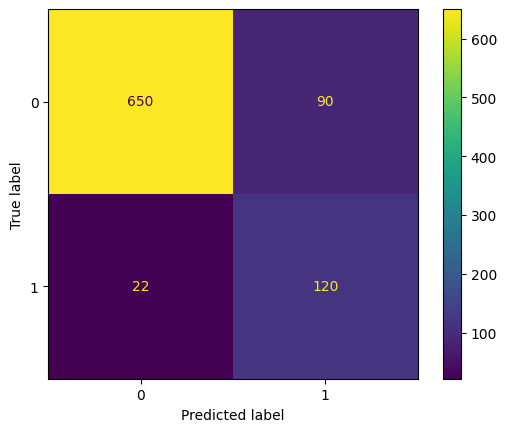

In [116]:
# Matriz de confusión
# =====================
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

En la matriz de confusión se observa que este modelo clasifica correctamente 650 para los empleados que se quedan y 120 para los que están dispuestos a irse. A su vez, el modelo clasifica de forma erronea 112 empleados, de los cuales 90 si permanecerían en la empresa y los clasifica como que se irian y 22 que los clasifica como que permanecerían cuando en verdad abandonarían la empresa.

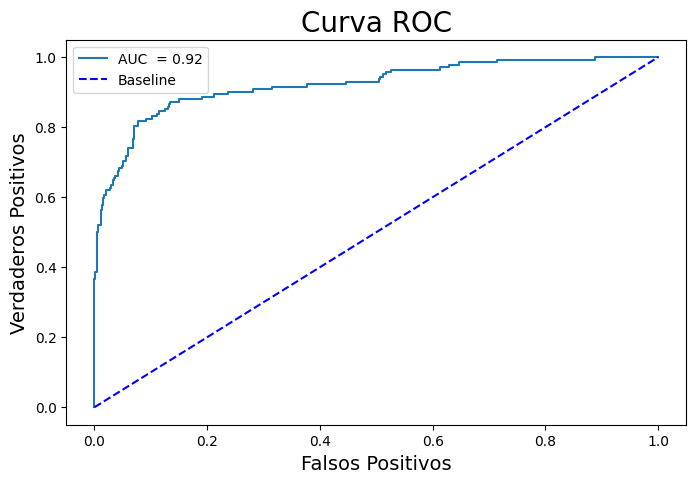

In [117]:
# Curva ROC y el área bajo la curva (AUC)
# =========================================
probs = clf.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend()

De la curva ROC y del valor AUC podemos analizar nuevamente el rendimiento de nuestro modelo. Debido a un valor de AUC (es el área bajo la curva) de 0,92 encontramos que nuestro clasificador proporciona un rendimiento medio indicando una sensibilidad alta (el valor de verdaderos positivos se acerca rapidamente a 1) y y una tasa baja de falsos positivos.

## Modelo XGBoost con búsqueda de hiper-parámetros

Los hiperparámetros del algoritmo de XGBOOST son:

        - max_depth: Define la profundidad máxima de cada árbol controlando la complejidad y evitando el sobreajuste.

        - learning_rate: Factor de escala para la contribución de cada árbol.

In [118]:
from scipy.stats import randint as sp_randint

# Búsqueda de los mejores hiper-parámetros
# ==============================================================================
num_transformer_dist = {'preprocessor__num__imputer__n_neighbors': list(range(2, 10)),
                        'preprocessor__num__imputer__add_indicator': [True, False]}

obj_transformer_dist = {'preprocessor__obj__imputer__strategy': ['most_frequent', 'constant'],
                        'preprocessor__obj__imputer__add_indicator': [True, False],
                        'preprocessor__obj__pca__n_components': list(range(2, 15))}

param_grid = {'classifier__max_depth'        : list(range(2, 20)),
              'classifier__learning_rate'    : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}

param_dist = {**num_transformer_dist, **obj_transformer_dist, **param_grid}

# Creamos el modelo
# ====================================================
xgboost_search = RandomizedSearchCV(clf,
                                   param_distributions=param_dist,
                                   n_iter=20)
np.random.seed(37)

Realizamos una búsqueda de los mejores hiper-pámetros del modelo para mejorar su rendimiento.

In [119]:
# Definimos el clasificador con todos sus procesos
# =============================================================================
xgboost_search

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIn...
                                                                  7, 8, 9, 10,
                                                                  11, 12, 13,
                                                                  14, 15, 16,
                                                                  17, 18, 19],
                                        'preprocessor__num__imputer__add_indicator': [True,
                                                                                      False],
                                        'preprocessor__num__imputer__n_neighbors': [2,
                                                                                    3,
                                                                                    4,
                                                                                    5,
                                                                                    6,
                                                                                    7,
                                                                                    8,
                                                                                    9],
                                        'preprocessor__obj__imputer__add_indicator': [True,
                                                                                      False],
                                        'preprocessor__obj__imputer__strategy': ['most_frequent',
                                                                                 'constant'],
                                        'preprocessor__obj__pca__n_components': [2,
                                                                                 3,
                                                                                 4,
                                                                                 5,
                                                                                 6,
                                                                                 7,
                                                                                 8,
                                                                                 9,
                                                                                 10,
                                                                                 11,
                                                                                 12,
                                                                                 13,
                                                                                 14]})

In [120]:
# Entrenamos el modelo
# ===================================
start_time = time.time()
xgboost_search.fit(X_train, y_train)
end_time = time.time()

print('Tiempo de entrenamiento de XGBoost - con ajuste de hiperparámetros: ', (end_time - start_time)/60, 'minutos')

Tiempo de entrenamiento de XGBoost - con ajuste de hiperparámetros:  2.9697738170623778 minutos


In [121]:
# Mejor resultado
# ===================================
xgboost_search.best_score_

0.8701822273119966

In [122]:
# Mejores valores para cada hiper-parámetro
# ============================================
xgboost_search.best_params_

{'preprocessor__obj__pca__n_components': 8,
 'preprocessor__obj__imputer__strategy': 'most_frequent',
 'preprocessor__obj__imputer__add_indicator': False,
 'preprocessor__num__imputer__n_neighbors': 4,
 'preprocessor__num__imputer__add_indicator': True,
 'classifier__max_depth': 18,
 'classifier__learning_rate': 0.2}

In [123]:
# Predecimos los resultados
# ======================================
y_pred = xgboost_search.predict(X_test)

print('Los resultados predecidos son:')
print('================================')
# Convertir arreglo a objeto Series de Pandas
y_pred_series = pd.Series(y_pred)

# Contar ocurrencias de cada valor único
value_counts = y_pred_series.value_counts()
print(value_counts)
print()

Los resultados predecidos son:
0    697
1    185
dtype: int64



Se observa que un mayor porcentaje de los empleados permaneceran en la empresa para estos datos y el modelo:

        - 0 empleados que permanecen de la empresa.
        - 1 empleados que se marcharían de la empresa.

In [124]:
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

# Calculamos el report de la clasificación
# ============================================
print(classification_report(y_test, y_pred))
print()

# Resultado de la precisión del balance de los datos
# ===================================================
xgbR = balanced_accuracy_score(y_test, y_pred)
print(f"El valor de balanced accuracy: {xgbR}")

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       740
           1       0.64      0.84      0.73       142

    accuracy                           0.90       882
   macro avg       0.81      0.87      0.83       882
weighted avg       0.91      0.90      0.90       882


El valor de balanced accuracy: 0.8744194899124477


En el resumen de resultados, se destaca una precisión del 97% para los empleados que deciden quedarse y del 64% para aquellos que optan por abandonar la empresa. Estos valores indican que el modelo es bastante preciso en la predicción de empleados en ambos grupos.

Sin embargo, al observar los valores de "recall" y "f1-score" para los empleados clasificados como propensos a marcharse, se aprecia que son medianamente altos. Esto indica que el modelo tiene una capacidad razonable para identificar correctamente esta categoría específica de empleados propensos a abandonar la empresa.

En cuanto a la precisión de balanceo, se obtiene un valor del 87,44%, lo cual indica un rendimiento sólido en términos de equilibrio entre ambas categorías. Esto sugiere que el modelo logra clasificar de manera efectiva tanto a los empleados que deciden quedarse como a aquellos que están propensos a marcharse.

Con estos resultados, se confirma que el modelo es bastante preciso en general en la clasificación de empleados, tanto en aquellos que se mantienen en la empresa como en aquellos que están propensos a marcharse

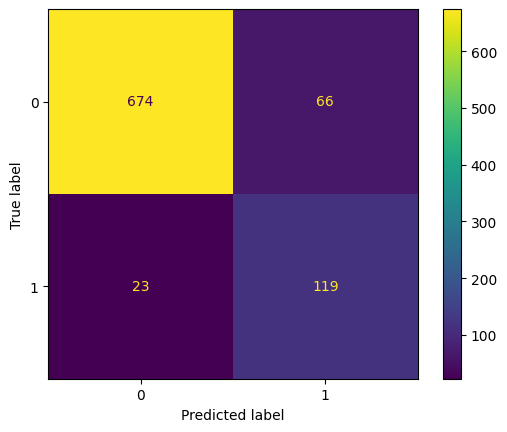

In [125]:
# Matriz de confusión
# =====================
cm = confusion_matrix(y_test, y_pred, labels=xgboost_search.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgboost_search.classes_)
disp.plot()
plt.show()

En la matriz de confusión se observa que este modelo clasifica correctamente 674 para los empleados que se quedan y 119 para los que están dispuestos a irse. A su vez, el modelo clasifica de forma erronea 89 empleados, de los cuales 66 si permanecerían en la empresa y los clasifica como que se irian y 23 que los clasifica como que permanecerían cuando en verdad abandonarían la empresa.

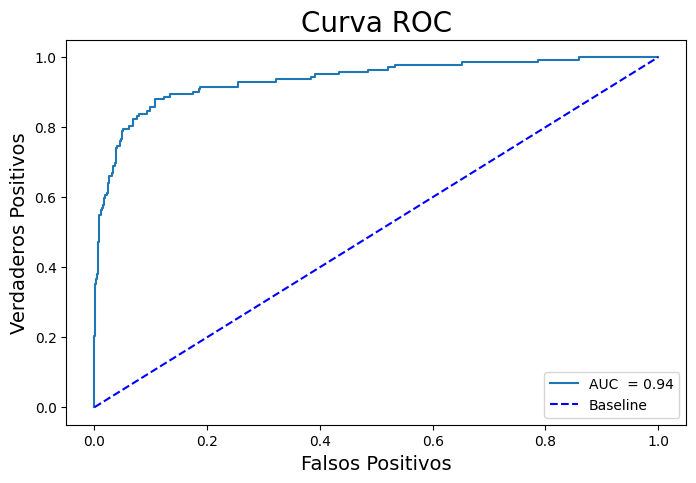

In [126]:
# Curva ROC y el área bajo la curva (AUC)
# =========================================
probs = xgboost_search.predict_proba(X_test)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend()

De la curva ROC y del valor AUC podemos analizar nuevamente el rendimiento de nuestro modelo. Debido a un valor de AUC (es el área bajo la curva) de 0,94 encontramos que nuestro clasificador proporciona un rendimiento medio indicando una sensibilidad alta (el valor de verdaderos positivos se acerca rapidamente a 1) y y una tasa baja de falsos positivos.

# COMPARAMOS RESULTADOS
-------------------------
Realizaremos una tabla para evaluar los resultados del balanced accuracy de cada uno de los modelos de clasificación.

Al experimentar con los diferentes modelos, cabe mencionar que no hemos realizado ajuste de hiper-parámetros en los modelos 'simples' ya que, posteriormente se realiza un ajuste con hiperparámetros permite alterar los mismos y encontrar el mejor valor para cada hiper-parámetro.

Una vez ejecutado los distintos métodos, procedemos a analizar el resultado de la medida de 'balanced accuracy' obtenidas tanto sin ajuste como con ajuste de hiper-parámetros.

No obstante, mencionar que el modelo más rápido a la hora de entrenarse es ...

In [127]:
# Tabla comparativa del Balanced accuracy de los diferentes modelos
# ===============================================================
modelos_accuracy = {
    'Sin ajuste' : [lg,bo,xgb],
    'Ajuste GridsearchCV' : [lgG,'-','-'],
    'Ajuste RandomizedSearchCV': ['-',boR,xgbR],
}

# Creamos la tabla --> Dataframe
# ===============================
tabla_accuracy = pd.DataFrame(modelos_accuracy, index=['LogisticRegression','Gradient Boosting','XGBoost'])

# Mostramos los resultados
# =========================
tabla_accuracy

,Sin ajuste,Ajuste GridsearchCV,Ajuste RandomizedSearchCV
LogisticRegression,0.705348,0.708051,-
Gradient Boosting,0.821422,-,0.852398
XGBoost,0.861724,-,0.874419


# Selección Características
----------------------------
Una vez hemos seleccionado el mejor método, intentaremos mejorarlo por medio de selección de características. Aplicaremos el modelo de las varianzas que a pesar de no ser una selección de características nos servirá para visualizar si alguno de los atributos no afecta a la predicción. El otro de los métodos que emplearemos sera el Mutual Info.

## Basados en la varianza

Realizamos este método a pesar de no estar considerada como una selección de características como tal para obtener una lista de aquellas variables que tienen suficiente relevancia para el problema.

Realizamos un selector para poder tratar los datos de entrada así como seleccionar el threshold de la varianza.

In [128]:
from sklearn.feature_selection import VarianceThreshold

# Umbral de varianzas
# ======================
selector = Pipeline(steps=[('preprocessor', preprocessor),
                      ('selector', VarianceThreshold(threshold=0.01))])

selector

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome',
       'NumCompaniesWorked', 'P...
      dtype='object')),
                                                 ('obj',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('pca',
                                                                   PCA(n_components=5))]),
                                                  Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18'],
      dtype='object'))])),
                ('selector', VarianceThreshold(threshold=0.01))])

In [129]:
# Dividimos los df de las variables de entrada y la variable objetivo
# =====================================================================
df_t = datos_df['Attrition']
sel = selector.fit(X)
sel_index = sel.named_steps['selector'].get_support()

# Comprobamos que obtengamos true y false para cada atributo
# ==========================================================
if len(sel_index) < X.shape[1]:
    sel_index = np.append(sel_index, [False] * (X.shape[1] - len(sel_index)))

# Observamos aquellos atributos que influyen en 'Attrition'
# =========================================================
df_vt = X.iloc[:, sel_index[:X.shape[1]]]

print("Atributos de interes")
print("===================")
print(df_vt.columns)

Atributos de interes
Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EducationField', 'Gender', 'JobLevel', 'JobRole', 'MaritalStatus',
       'MonthlyIncome', 'NumCompaniesWorked', 'Over18', 'PercentSalaryHike',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany'],
      dtype='object')


Obtenemos que son 25 atributos de interes de los 30 originales, lo que nos indica que hay 5 atributos que aportan a la predicción de los resultados. A su vez, comprobaremos cuales de esos atributos son los más relevantes de cara a predecir los resultados por medio de selección de características.

## Mutual info
Calcula el valor de información mutua de cada una de las variables independientes con respecto a la variable dependiente y selecciona las que tienen mayor ganancia de información (al estilo de la ganancia de información de los árboles de decisión). En otras palabras, básicamente mide la dependencia de las características con el valor objetivo. Cuanto mayor sea la puntuación, mayor será la dependencia.

In [130]:
from sklearn.feature_selection import mutual_info_classif

# Cálculo de la información mutua de cada atributo
# =================================================
threshold = 12  # the number of most relevant features
high_score_features = []

feature = preprocessor.fit_transform(X)

feature_scores = mutual_info_classif(feature, df_t, random_state=37)

for score, f_name in sorted(zip(feature_scores, X.columns), reverse=True)[:threshold]:
    print(f_name, score)
    high_score_features.append(f_name)
df_mic = X[high_score_features]

Education 0.1042463590313305
StockOptionLevel 0.05040170043715597
TotalWorkingYears 0.047215501131971704
TrainingTimesLastYear 0.0462988395415167
PercentSalaryHike 0.04466203867927154
YearsAtCompany 0.04108705232193488
Age 0.031048498399592006
JobRole 0.022914775491566397
MonthlyIncome 0.02061513611721355
Over18 0.020576126395910777
hrs 0.018936682100862967
NumCompaniesWorked 0.011369294754830728


Para seleccionar el parámetro threshold observamos el resultado de los scores de cada parámetro y viendo si hay alguno atributo no relevante. A su vez, observaremos los resultados de los scores seleccionando el número en base a un intervalo.

In [131]:
print("Atributos de mayor valor")
print("========================")
print(df_mic.columns)
print()

print("Scores de cada atributo")
print("========================")
print(feature_scores)

Atributos de mayor valor
Index(['Education', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'PercentSalaryHike', 'YearsAtCompany', 'Age',
       'JobRole', 'MonthlyIncome', 'Over18', 'hrs', 'NumCompaniesWorked'],
      dtype='object')

Scores de cada atributo
[1.89366821e-02 3.46569477e-03 5.88982212e-03 0.00000000e+00
 1.46670661e-05 6.30682715e-03 7.54166092e-03 3.10484984e-02
 9.67992485e-03 5.74855669e-03 0.00000000e+00 1.04246359e-01
 0.00000000e+00 0.00000000e+00 9.13165348e-03 2.29147755e-02
 8.32740182e-03 2.06151361e-02 1.13692948e-02 2.05761264e-02
 4.46620387e-02 5.04017004e-02 4.72155011e-02 4.62988395e-02
 4.10870523e-02]


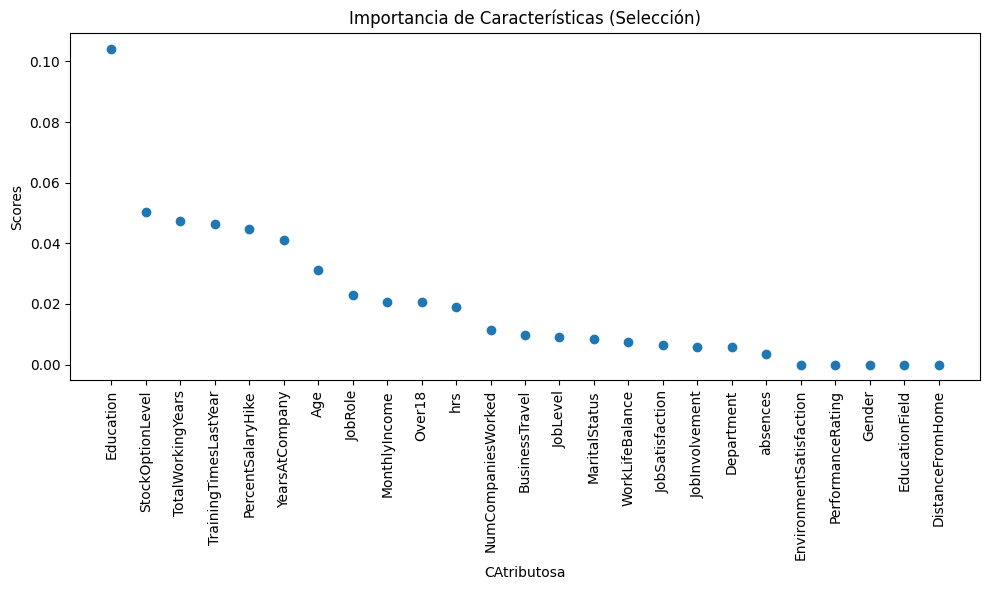

In [132]:
import matplotlib.pyplot as plt

# Obtener los nombres y puntajes de características ordenados por puntaje
feature_scores_sorted = sorted(zip(feature_scores, X.columns), reverse=True)
feature_names = [f_name for score, f_name in feature_scores_sorted]
scores = [score for score, f_name in feature_scores_sorted]

# Crear la gráfica de dispersión
plt.figure(figsize=(10, 6))
#plt.barh(range(len(scores)), scores, align='center')
plt.scatter(range(len(scores)), scores)
plt.xticks(range(len(feature_names)), feature_names, rotation=90)
plt.xlabel('CAtributosa')
plt.ylabel('Scores')
plt.title('Importancia de Características (Selección)')
plt.tight_layout()
plt.show()

Realizamos una división de los nuevos datos (solo tienen los atributos especificados) destinando un 80% para el entrenamiento y un 20% para la evaluación. Indicar que debido a que los datos se encuentran desbalanceados empleamos particiones estratificadas.

In [133]:
# División de los datos
# =======================
X_train2, X_test2, y_train2, y_test2 = train_test_split(df_mic, df_t, stratify = df_t, test_size=0.2, train_size=0.8, random_state=37, shuffle = True)

np.random.seed(37)

Procedemos a codificar la salida 'Attribution' dicotómica ('SÍ' o 'NO') con LabelEncoder.

In [134]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)

# Codificamos la salida
# =======================================
y_test2 = le.transform(y_test2)
y_train2 = le.transform (y_train2)

# Mejoras de resultados del modelo final
-----------------------------------------
Aplicamos el modelo XGBoost solo empleando los atributos más relevantes onbtenidos al realizar la selección de características mediante el método de filtrado 'mutual_info'

Observamos los nuevos datos de entrenamiento para analizar los atributos seleccionados. El número de atributos vas en función del rango de los valores de los atributos, habiendo seleccionado para nuestro caso todos aquellos atributos de un valor mayor a 0,03.

In [135]:
X_train2.head()

,Education,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,PercentSalaryHike,YearsAtCompany,Age,JobRole,MonthlyIncome,Over18,hrs,NumCompaniesWorked
3009,1,1.0,NaN,0,17.0,1.0,39.0,Laboratory Technician,42840.0,NaN,NaN,NaN
2767,1,NaN,37.0,2,11.0,6.0,NaN,Sales Executive,26440.0,Y,5.999277,4.0
1290,3,3.0,16.0,3,17.0,5.0,37.0,Sales Executive,52070.0,Y,6.491229,4.0
819,3,2.0,NaN,2,17.0,9.0,29.0,Research Scientist,109340.0,Y,6.313620,6.0
1938,2,0.0,NaN,3,12.0,4.0,31.0,Sales Executive,65020.0,Y,5.970400,1.0


## Creamos un nuevo preprocesador
---------------------------------
Procedemos a realizar un nuevo tratamiento de las variables de entrada. Dado que hemos identificado diferentes tipos de variables y hemos reducido el número de atributos.

Aplicarmos los tratamientos específicos para cada tipo de variable, donde buscamos como se ha indicado anteriormente asegurar la calidad y compatibilidad de los datos en la construcción de los modelos, permitiéndonos aprovechar toda la información disponible y facilitando la interpretación y el análisis de los resultados obtenidos.

In [136]:
X_train2.dtypes

Education                  int64
StockOptionLevel         float64
TotalWorkingYears        float64
TrainingTimesLastYear      int64
PercentSalaryHike        float64
YearsAtCompany           float64
Age                      float64
JobRole                   object
MonthlyIncome            float64
Over18                    object
hrs                      float64
NumCompaniesWorked       float64
dtype: object

Seleccionamos solos aquellos atributos con los que entrenaremos este nuevo modelo final para crear el preprocesador.

In [137]:
obj_cols2 = X_train2.select_dtypes(include="object").columns
num_cols2 = X_train2.select_dtypes(exclude="object").columns

In [138]:
# Tratamos las variables object
# ======================================
obj_transformer2 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # De todos los que tiene coge el más frecuente
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Tratamos las variables numéricas
# ======================================
num_transformer2 = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

Realizamos los mismos procesos que hemos realizado anteriormente, quitando el método 'PCA' ya que no es necesario realizar distintos modelos de componenentes para pocas variables de tipo object.

In [139]:
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', num_transformer2, num_cols2),
        ('obj', obj_transformer2, obj_cols2)
    ])

In [140]:
# Como funciona nuestro transformador
# ====================================
preprocessor2

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('scaler', RobustScaler())]),
                                 Index(['Education', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'PercentSalaryHike', 'YearsAtCompany', 'Age',
       'MonthlyIncome', 'hrs', 'NumCompaniesWorked'],
      dtype='object')),
                                ('obj',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['JobRole', 'Over18'], dtype='object'))])

Se observa que este nuevo preprocesador aplica las transformaciones explicadas anteriormente.

## Modelo final XGBoost mejorado
--------------------------------
Realizamos un modelo final con la intención de compararlo con nuestro mejor modelo. Este nuevo modelo, será el clasificador del XGBoost aplicando búsqueda de hiper-parámetros por el método 'Randomized Search CV'. Con unos datos de entrada en el que reduciremos el número de atributos para predecir los resultados.

Creamos el nuevo clasificador con el nuevo preprocesador especificado para los atributos seleccionados

In [141]:
# Para balancear el modelo
# ==========================
positive_records = y_train2.sum()
negative_records = len(y_train2) - positive_records
spw2 = negative_records - positive_records

# Pipeline del clasificador
# =================================================
clf_final = Pipeline(steps=[('preprocessor', preprocessor2),
                      ('classifier', XGBClassifier(scale_pos_weight = spw2, random_state=37))])

Aplicamos la misma búsqueda de hiper-parámetros que hemos aplicado para nuestro mejor modelo.

In [142]:
# Búsqueda de los mejores hiper-parámetros
# ==============================================================================
num_transformer_dist = {'preprocessor__num__imputer__n_neighbors': list(range(2, 10)),
                        'preprocessor__num__imputer__add_indicator': [True, False]}

obj_transformer_dist = {'preprocessor__obj__imputer__strategy': ['most_frequent', 'constant'],
                        'preprocessor__obj__imputer__add_indicator': [True, False]}

param_grid = {'classifier__max_depth'        : list(range(2, 20)),
              'classifier__learning_rate'    : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}

param_dist = {**num_transformer_dist, **obj_transformer_dist, **param_grid}

# Creamos el modelo
# ====================================================
xgboost_search_final = RandomizedSearchCV(clf_final,
                                   param_distributions=param_dist,
                                   n_iter=20)
np.random.seed(37)

In [143]:
# Entrenamos el mejor modelo con los atributos seleccionados
# ============================================================
start_time = time.time()
xgboost_search_final.fit(X_train2, y_train2)
end_time = time.time()

print('Tiempo de entrenamiento de XGBoost - sin ajuste de hiperparámetros: ', end_time - start_time, 'segundos')

Tiempo de entrenamiento de XGBoost - sin ajuste de hiperparámetros:  124.12212061882019 segundos


In [144]:
# Predecimos los resultados
# ======================================
y_pred = xgboost_search_final.predict(X_test2)

print('Los resultados predecidos son:')
print('================================')
# Convertir arreglo a objeto Series de Pandas
y_pred_series = pd.Series(y_pred)

# Contar ocurrencias de cada valor único
value_counts = y_pred_series.value_counts()
print(value_counts)

Los resultados predecidos son:
0    707
1    175
dtype: int64


Se observa que un mayor porcentaje de los empleados permaneceran en la empresa para estos datos y el modelo:

        - 0 empleados que permanecen de la empresa.
        - 1 empleados que se marcharían de la empresa.

In [145]:
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

# Calculamos el report de la clasificación
# ============================================
print(classification_report(y_test2, y_pred))
print()

# Resultado de la precisión del balance de los datos
# ===================================================
mejor_modelo = balanced_accuracy_score(y_test2, y_pred)
print(f"El valor de balanced accuracy - XGBoost: {mejor_modelo}")

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       740
           1       0.67      0.82      0.74       142

    accuracy                           0.91       882
   macro avg       0.82      0.87      0.84       882
weighted avg       0.92      0.91      0.91       882


El valor de balanced accuracy - XGBoost: 0.8727826417967264


En el resumen de resultados, se destaca una precisión del 96 % para los empleados que deciden quedarse y del 67% para aquellos que optan por abandonar la empresa. Estos valores indican que el modelo es bastante preciso en la predicción de empleados en ambos grupos.

Sin embargo, al observar los valores de "recall" y "f1-score" para los empleados clasificados como propensos a marcharse, se aprecia que son medianamente altos. Esto indica que el modelo tiene una capacidad razonable para identificar correctamente esta categoría específica de empleados propensos a abandonar la empresa.

En cuanto a la precisión de balanceo, se obtiene un valor del 87,27%, lo cual indica un rendimiento sólido en términos de equilibrio entre ambas categorías. Esto sugiere que el modelo logra clasificar de manera efectiva tanto a los empleados que deciden quedarse como a aquellos que están propensos a marcharse.

Con estos resultados, se confirma que el modelo es bastante preciso en general en la clasificación de empleados, tanto en aquellos que se mantienen en la empresa como en aquellos que están propensos a marcharse

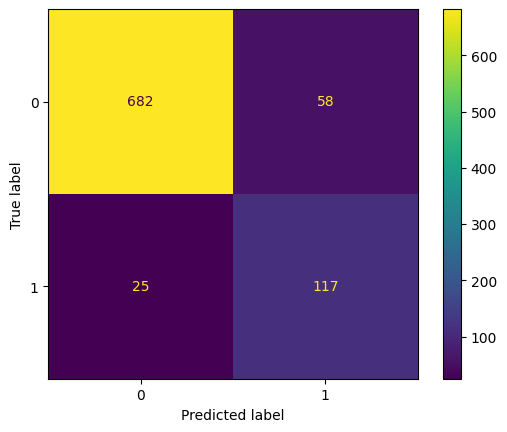

In [146]:
# Matriz de confusión
# =====================
cm = confusion_matrix(y_test2, y_pred, labels=xgboost_search_final.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgboost_search_final.classes_)
disp.plot()
plt.show()

En la matriz de confusión se observa que este modelo clasifica correctamente 682 para los empleados que se quedan y 117 para los que están dispuestos a irse. A su vez, el modelo clasifica de forma erronea 83 empleados, de los cuales 58 si permanecerían en la empresa y los clasifica como que se irian y 25 que los clasifica como que permanecerían cuando en verdad abandonarían la empresa.

Estos resultados erroneos coinciden con el resultado obtenido anteriormente para el 'balanced accuracy' dada la precisión del modelo.

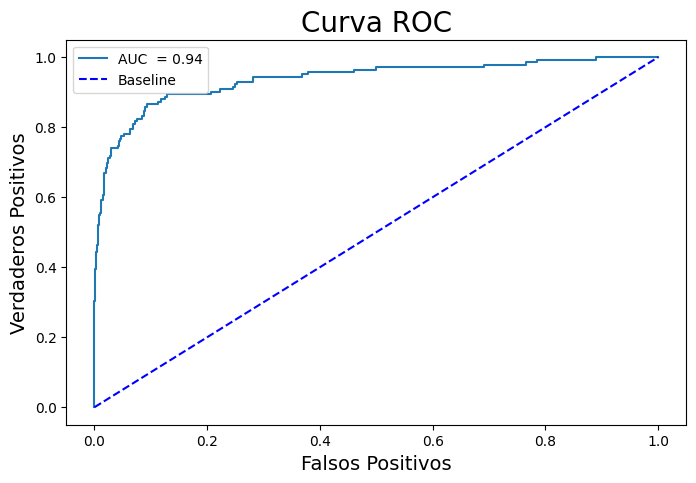

In [147]:
# Curva ROC y el área bajo la curva (AUC)
# =========================================
probs = xgboost_search_final.predict_proba(X_test2)[:, 1]

auc = metrics.roc_auc_score(y_test, probs)
fpr, tpr, thresholds = metrics.roc_curve(y_test2, probs)

plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label=f'AUC  = {auc:.2f}')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
plt.title('Curva ROC', size=20)
plt.xlabel('Falsos Positivos', size=14)
plt.ylabel('Verdaderos Positivos', size=14)
plt.legend()

De la curva ROC y del valor AUC podemos analizar nuevamente el rendimiento de nuestro modelo. Debido a un valor de AUC (es el área bajo la curva) de 0,94 encontramos que nuestro clasificador proporciona un rendimiento medio indicando una sensibilidad alta (el valor de verdaderos positivos se acerca rapidamente a 1) y y una tasa baja de falsos positivos.

### Comparamos el modelo final con selección características

In [148]:
# Tabla comparativa del Balanced accuracy de los diferentes modelos
# ===============================================================
modelo_final_accuracy = {
    'Ajuste RandomizedSearchCV': [xgbR,mejor_modelo],
}

# Creamos la tabla --> Dataframe
# ===============================
tabla_final_accuracy = pd.DataFrame(modelo_final_accuracy, index=['XGBoost','Modelo_XGBoost_Mejorado'])

# Mostramos los resultados
# =========================
tabla_final_accuracy

,Ajuste RandomizedSearchCV
XGBoost,0.874419
Modelo_XGBoost_Mejorado,0.872783


Debido a la precisión obtenida para cada uno de los modelos y la complejidad del problema. Consideramos que para este caso, el mejor modelo es aquel que emplea mayor información para predecir los resultados, ya que, a pesar de tener un mayor coste temporal, este no supone excesivamente elevado. No obstante mecionar, que en caso de aumentar el coste temporal sería recomendable aplicar el método XGBoost con selección de características.

Mencionar que nos sorprende la escasa diferencia entre la precisión de ambos modelos. 

# Modelo final
----------------
Guardardamos el modelo final tras entrenarlo en un archivo llamado 'modelo_final.pkl'

In [149]:
import pickle
# Modelo final
# =================================================
start_time = time.time()
modelo_final = xgboost_search.fit(X_train, y_train)
end_time = time.time()

# Entrenamiento del modelo final
# ==============================================================================
print ("El tiempo de entrenamiento del modelo es: ", (end_time - start_time))

# Guardamos el modelo final en un archivo pkl
# ==============================================================================
pkl_filename = "modelo_final.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(modelo_final, file)

# Cerramos el archivo
file.close()

El tiempo de entrenamiento del modelo es:  182.57417464256287
